# All

## Import/read

In [20]:
import os
import time
import warnings
from datetime import datetime
from types import SimpleNamespace

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import HasTraits, Int, Unicode, default
from copy import deepcopy
import pickle

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [21]:
data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"
bayesian_run_path = "../data/bayesian_runs/"


def r(filename, sub_folder="kaggle", delimiter=","):
    return pd.read_csv(
        os.path.join(data_path, sub_folder, filename), delimiter=delimiter
    )

In [22]:
df_census = r("census_starter.csv")
df_test = r("test.csv")
df_train = r("train.csv")
df_submission = r("sample_submission.csv")

df_boundaries = r("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")

### Add census, year, fix dates etc

In [23]:
def fix_df_train(df_train):
    df = df_train.copy()

    # Add year
    df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
    df["year"] = df["first_day_of_month"].dt.year.astype(int)

    # Add df_census to df
    cols = list(df_census.columns)
    cols.remove("cfips")

    t0 = df_census.melt("cfips", cols)
    t0["year"] = t0["variable"].str.split("_").str[-1].astype(int)
    t0["variable_name"] = t0["variable"].str.rsplit("_", expand=False, n=1).str[0]

    t1 = pd.pivot_table(t0, "value", ["cfips", "year"], "variable_name").reset_index()

    # Census data is lagging 2 years
    t1["year"] = t1["year"] + 2

    df = pd.merge(df, t1, "left", left_on=["cfips", "year"], right_on=["cfips", "year"])

    # Add month
    df["month"] = df["first_day_of_month"].dt.month

    return df

In [24]:
df_train = fix_df_train(df_train)

t = df_train[df_train.isna().any(axis=1)]
if t.shape[0] != 22:
    raise Exception("Nan counts used to be 22... something changed")

### Weather save/load

In [25]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:
            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [26]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [27]:
df_weather = pd.read_csv(path_weather)

### Baseline model

#### Feature functions

In [28]:
def add_previous_targets(t, added_feature_cols, **kwargs):
    """
    Add rolling windows and/or shifted values

    window: list
        List of windows to add. [2, 5] will add two columns with rolling window 2 and 5.
    shifts: list
        List of recents shifts to add. [2, 5] will add two columns with shifts of 2 and 5.
    """

    def add_previous_mean_x(
        t: pd.DataFrame, added_feature_cols: list, f_col: str, window: int
    ):
        # f_col = "{}".format(col, window)
        previous = (
            t.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .rolling(window)
            .mean()
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    def add_last_value(
        t: pd.DataFrame, added_feature_cols: list, f_col: str, shift: int
    ):
        # f_col = "{}{}".format(col, shift)
        previous = (
            t.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .shift(shift)
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    def filter_relevant_keys_and_astype_int(d: dict, filter_col_start: str) -> dict:
        """
        Simply filter the dictionary, convert the float to int and remove duplicates
        """
        filtered_d = {k: v for k, v in d.items() if k.startswith(filter_col_start)}
        f_data = pd.DataFrame.from_dict(
            filtered_d, orient="index", columns=["orig_val"]
        )
        f_data["int_val"] = f_data["orig_val"].astype(int)

        return (
            f_data.drop_duplicates(subset=["int_val"])
            .drop(columns=["orig_val"])
            .to_dict()["int_val"]
        )

    def loop_dict(t, added_feature_cols, col, f):
        d = filter_relevant_keys_and_astype_int(kwargs, col)
        for bay_col, v in d.items():
            if v > 0:
                t = f(t, added_feature_cols, bay_col, v)

    # Rolling mean features
    col = "target_mean_rolling_"
    loop_dict(t, added_feature_cols, col, add_previous_mean_x)

    col = "target_shift_"
    loop_dict(t, added_feature_cols, col, add_last_value)

    # d = filter_relevant_keys_and_astype_int(kwargs, col)
    # for v, bay_col in d.items():
    #     if v > 0:
    #         t = add_previous_mean_x(t, added_feature_cols, col, bay_col, window=v)

    # Shifted
    # col = "target_shift_"
    # d = filter_relevant_keys_and_astype_int(kwargs, col)
    # for v, bay_col in d.items():
    #     if v > 0:
    #         t = add_last_value(t, added_feature_cols, col, bay_col, shift=v)

    return t

In [29]:
def correlated_states(df_train):
    """
    Find states that correlate well in terms of change in ´microbusiness_density´
    """
    cols_state_relation = []
    dfs = pd.DataFrame([])
    new_col_raw = "mean"

    # Rolling
    t0 = (
        df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    t1 = t0.pivot_table(new_col_raw, "first_day_of_month", "state").sort_index().corr()
    # plt.imshow(t1.values, cmap="hot", interpolation="nearest")
    # plt.show()

    t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
    t5 = t5[t5["state"] != t5["other_state"]]

    # Clean pairs of same correlations
    t5 = t5.sort_values("corr").reset_index(drop=True)
    cols = ["state", "other_state"]
    t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
    t5 = t5.drop_duplicates()

    # Cluster
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))
    t5["cluster"] = clustering.labels_

    # Iterate through pairs and add state means to each other
    corr_states = t5[abs(t5["corr"]) > 0.9]

    # Append one month.
    t2 = df_train.copy()
    t2["first_day_of_month"] = t2["first_day_of_month"] + pd.DateOffset(months=1)
    t0 = (
        t2.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    # Iterate over the pairs
    for pair in corr_states.values:
        group = pair[:2]
        corr = pair[2]

        switched = t0[t0["state"].isin(group)].copy()

        state_0 = group[0]
        state_1 = group[1]

        s = "{}_{}_rolling_microbusiness_density"
        col_state_0 = s.format(state_0, state_1)
        col_state_1 = s.format(state_1, state_0)

        sw = pd.pivot_table(
            switched, new_col_raw, "first_day_of_month", "state"
        ).rename(columns={state_0: col_state_0, state_1: col_state_1})

        def boo(df, sw, state, col_state, corr):
            """
            I think it switches state labels.
            """
            corr_col = "corr_" + col_state
            # sw[corr_col] = corr

            df_state_t = sw[[col_state]].reset_index()
            df_state_t["state"] = state

            # df = pd.merge(
            #     df,
            #     df_state_t,
            #     "left",
            # left_on=["state", "first_day_of_month"],
            # right_on=["state", "first_day_of_month"],
            # )

            return (df_state_t, corr_col)

        df_state_t_0, corr_col_0 = boo(df_train, sw, state_1, col_state_0, corr)
        df_state_t_1, corr_col_1 = boo(df_train, sw, state_0, col_state_1, corr)

        # Append results to list
        if dfs.shape[0] == 0:
            dfs = pd.merge(
                df_state_t_0,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        else:
            dfs = pd.merge(
                dfs,
                df_state_t_0,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
            dfs = pd.merge(
                dfs,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        # cols_state_relation.extend([corr_col_0, corr_col_1])
        cols_state_relation.extend([col_state_0, col_state_1])

    return (dfs, cols_state_relation)

In [30]:
def state_cluster(df_train):
    t0 = df_train.groupby("state")["microbusiness_density"].agg(["mean", "std"])
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(t0.values)
    t0["cluster"] = clustering.labels_

    return t0.reset_index()[["state", "cluster"]]

In [109]:
def time_arrow(df: pd.DataFrame, added_feature_cols):
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    f_col = 'time_arrow'
    
    seconds_since = df['first_day_of_month'].astype('int64')//1e9
    df[f_col] = NormalizeData(seconds_since)
    
    added_feature_cols.append(f_col)
    
    return df

In [114]:
state_cluster(df_train)

,state,cluster
0,Alabama,0
1,Alaska,1
2,Arizona,2
3,Arkansas,0
4,California,3
...,...,...
46,Virginia,1
47,Washington,2
48,West Virginia,0
49,Wisconsin,0


##### Maybe pile

In [31]:
def ups_downs(df_train):
    """
    Counts ups and downs until the latest known time. Returns the percetage of ups/downs
    """
    col = "microbusiness_shift_bool_over_pct"
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    added_feature_cols.append(col)

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

#### Misc functions

In [47]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)


def remove_outliers(train, outlier_multiplier):
    """
    Remove outlies. Should be run on train only
    """
    max_density = (
        train.groupby("cfips")["microbusiness_density"]
        .mean()
        .rename("max_microbusiness_density")
        .reset_index()
    )
    max_density["max_microbusiness_density"] = (
        max_density["max_microbusiness_density"] * outlier_multiplier
    )
    t1 = pd.merge(
        train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
    )
    
    idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
    t = train.loc[idx].copy()

    return t


def smape(pred, eval_data):
    
    if hasattr(eval_data, 'label'):
        A = eval_data.label # Used by lightgbm
    else:
        A = eval_data # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

def remove_empty_folders(path_abs):
    walk = list(os.walk(path_abs))
    for path, _, _ in walk[::-1]:
        if len(os.listdir(path)) == 0:
            os.rmdir(path)

def save_bayesian_results(loss_fn: str, results: list[dict], best: dict):
    
    def save_pkl(full_path, data):
        with open(full_path, 'wb') as f:
            pickle.dump(data, f)
    
    # Create folders
    dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    subfolder = "{}_{}".format(dt, abs(round(best['target'], 4)))
    bay_result_dir = os.path.join(bayesian_run_path, loss_fn, subfolder)

    if not os.path.exists(bay_result_dir):
        os.makedirs(bay_result_dir)

    # Full paths
    result_path = os.path.join(bay_result_dir, 'result.pkl')
    best_path = os.path.join(bay_result_dir, 'best.pkl')

    # Save pickles
    save_pkl(result_path, results)
    save_pkl(best_path, best)
    
    # Remove empty folders that can trash the place
    remove_empty_folders(bayesian_run_path)

def read_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [33]:
# def smape(pred, eval_data):
#     if hasattr(eval_data, 'label'):
#         A = eval_data.label
#     else:
#         A = eval_data
#     F = pred

#     value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
#     return "smape", value, False

#### Prepare data

In [34]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [110]:
class PrepareData:
    def __init__(self, df_train):
        self.df_train = df_train.copy()  # Original data
        self._df = None  # Dataframe with

        self._col_target: list = ["microbusiness_density"]
        self._col_target_shifted: str = ["shifted_microbusiness_density"]
        self._col_cfips: str = "cfips"
        self._col_first_day_of_month = "first_day_of_month"

        # Caching the generated dataset incase same data asked again
        self._args = None

        self._lgb_train: lgb.Dataset = None
        self._lgb_eval: lgb.Dataset = None
        self._df: pd.DataFrame = None
        self._cat_f: list = None
        self._features: list = None

        # self._debug_different_shifts = {} # Debugging purposes

    def prepare_data_for_model(self, args):
        # Split and validation strategy
        for shift in args["shifts"]:
            # print('shift ---', shift)

            added_feature_cols = []
            cols_drop_or_not = [
                "median_hh_inc",
                "pct_bb",
                "pct_college",
                "pct_foreign_born",
                "pct_it_workers",
                "shift_in_months",
                "state",
            ]

            df = self.df_train.copy()
            df, self._features = self._shift_target(df, shift, added_feature_cols)

            # Legacy
            self._args = args

            # Feature engineering
            self._df, self._features, self._cat_f = self._create_data(
                df, added_feature_cols, args
            )

            # Remove some columns according to bayesian.
            df = self._drop_col_maybe(df, cols_drop_or_not, args)

            # Split by logic
            (self._lgb_train, self._lgb_eval, df) = self._split_data(**args)

            res = (
                self._lgb_train,
                self._lgb_eval,
                df,
                self._cat_f,
                self._features,
                shift,
            )
            
            yield res

    def _shift_target(self, df, shift, added_feature_cols):
        """
        Shift data so that I can predict 1,2 and 3 months in advance
        """

        f_col = "shift_in_months"

        # assert shift >= 1, "Shift has to be more than one"

        df[self._col_target_shifted] = (
            df.sort_values([self._col_cfips, self._col_first_day_of_month])
            .groupby(self._col_cfips)[self._col_target]
            .shift(shift)
        )
        
        df = df.dropna(subset=self._col_target_shifted).copy()

        df[f_col] = shift

        added_feature_cols.append(f_col)

        return (df, added_feature_cols)
            
            
    def _create_data(self, df, added_feature_cols, args):
        # Feature engineering
        df, added_feature_cols = self._feature_engineering(df, added_feature_cols, args)

        # Mape needs values over 1. When not using mape, irrelevant
        target_multiplier = 1
        df[self._col_target_shifted] = df[self._col_target_shifted] * target_multiplier

        # Handle categorical features
        cat_f = ["state"]
        df[cat_f] = df[cat_f].astype("category")

        # print('added_feature_cols', added_feature_cols)
        features = (
            [
                "median_hh_inc",
                "pct_bb",
                "pct_college",
                "pct_foreign_born",
                "pct_it_workers",
            ]
            + added_feature_cols
            + cat_f
        )

        return (df, features, cat_f)

    def _feature_engineering(self, df, added_feature_cols, args):
        """
        0 means feature will not be included
        """
        # Time arrow
        df = time_arrow(df, added_feature_cols)
        
        # Add previous target info
        df = add_previous_targets(df, added_feature_cols, **args)

        return (df, added_feature_cols)

    def _split_data(self, drop_na, outlier_multiplier, **kwargs):
        df = self._df.copy()
        if drop_na > 0.5:
            self._df = self._df.dropna()

        # Split train/val split according to dates
        dates_train, dates_val = split_dates(df)
        train = df[df["first_day_of_month"].isin(dates_train)]
        val = df[df["first_day_of_month"].isin(dates_val)]

        # Remove outliers
        train = remove_outliers(train, outlier_multiplier)
        
        # print('df 0s', df[df[self._col_target_shifted] == 0].shape)
        # print('df 0s', df[df['shifted_microbusiness_density'] == 0].shape)
        # print('self._col_target_shifted', self._col_target_shifted)
        
        # print('train 0s', train[train[self._col_target_shifted] == 0].shape)
        # print('train[self._col_target_shifted].value_counts()', train[self._col_target_shifted].value_counts())
        
        
        x_train = train[self._features]
        y_train = train[self._col_target_shifted]

        x_val = val[self._features]
        y_val = val[self._col_target_shifted]
        
        # print('y_val 0s', y_val[y_val['shifted_microbusiness_density'] == 0].shape)

        # lgb_train = lgb.Dataset(x_train, y_train)
        lgb_train = lgb.Dataset(
            x_train, y_train, categorical_feature=self._cat_f, free_raw_data=False
        )
        lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train, free_raw_data=False)

        return (lgb_train, lgb_eval, df)

    def _drop_col_maybe(self, df, cols_drop_or_not: list, args: dict):
        cols_to_drop = []
        for col in cols_drop_or_not:
            if args[col] < 0.5:
                cols_to_drop.append(col)

        return df.drop(columns=cols_to_drop)

In [97]:
seconds_since = df_train['first_day_of_month'].astype('int64')//1e9

In [106]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

seconds_since = df['first_day_of_month'].astype('int64')//1e9
time_keeper = NormalizeData(seconds_since)

In [107]:
NormalizeData(seconds_since)

0         0.000000
1         0.026793
2         0.052723
3         0.079516
4         0.105445
            ...   
122260    0.894555
122261    0.920484
122262    0.947277
122263    0.974071
122264    1.000000
Name: first_day_of_month, Length: 122265, dtype: float64

In [100]:
(seconds_since / seconds_since.max())

0         0.939946
1         0.941555
2         0.943112
3         0.944721
4         0.946278
            ...   
122260    0.993668
122261    0.995225
122262    0.996834
122263    0.998443
122264    1.000000
Name: first_day_of_month, Length: 122265, dtype: float64

In [101]:
(seconds_since / seconds_since.min())

0         1.000000
1         1.001712
2         1.003368
3         1.005080
4         1.006737
            ...   
122260    1.057154
122261    1.058811
122262    1.060522
122263    1.062234
122264    1.063891
Name: first_day_of_month, Length: 122265, dtype: float64

In [105]:
(seconds_since.max() - seconds_since.min()) / seconds_since.min()

0.06389088298636038

In [99]:
seconds_since.max()

1664582400.0

In [89]:
class LightGBMBayesian:
    def __init__(self, PrepareData, df_train):
        self.prepare_data: PrepareData = PrepareData(df_train)

        self._debug_different_shifts: dict = {}

        # Shows if there are columns which are not optimized by bayesian.
        self._warn_bayes_not_optimize_columns = True

    def optimize(self, bounds, init_points=1, n_iter=1, xi=1e-4):
        # Initialize the Bayesian Optimization
        self.optimizer = BayesianOptimization(self.train_model, bounds, random_state=0)

        # af = bayes.UtilityFunction('poi', kappa=100)
        acquisition_function = bayes.UtilityFunction(kind="ei", xi=xi)

        # Run the optimization
        self.optimizer.maximize(
            # init_points=100, n_iter=100
            init_points=init_points,
            n_iter=n_iter,
            acquisition_function=acquisition_function,
        )

        # Get the best hyperparameters
        best_params = self.optimizer.max["params"]
        print("Best hyperparameters: ", best_params)

    def train_model(
        self,
        shifts=[-1, -2, -3],
        early_stopping=True,
        log_evaluation=True,
        num_threads=6,
        # verbose=2,
        **kwargs,
    ):
        # print("kwargs", kwargs)

        saved_args = locals()
        saved_args.update(saved_args["kwargs"])
        del saved_args["self"], saved_args["kwargs"]
        scores = []

        # print('train_model - saved_args', saved_args)

        for (
            lgb_train,
            lgb_eval,
            df,
            cat_f,
            features,
            shift,
        ) in self.prepare_data.prepare_data_for_model(saved_args):
            self._check_bayes_optimize_columns(saved_args, features)

            params = {
                "boosting_type": "gbdt",
                "objective": "mae",
                "metric": "None",
                "first_metric_only": True,
                # "num_iterations": int(num_iterations),
                "num_leaves": int(kwargs["num_leaves"]),
                "learning_rate": kwargs["learning_rate"],
                "subsample": kwargs["subsample"],
                "colsample_bytree": kwargs["colsample_bytree"],
                "reg_alpha": kwargs["reg_alpha"],
                "reg_lambda": kwargs["reg_lambda"],
                # "verbose": verbose,
                "num_threads": num_threads,
            }

            callbacks = []
            # Stop earlier if no changes
            if early_stopping:
                callbacks.append(lgb.early_stopping(100))

            # Log every X-th line
            if log_evaluation:
                callbacks.append(lgb.log_evaluation(100))

            # Can be used to supress warnings
            # with warnings.catch_warnings():
            #     warnings.filterwarnings("ignore", category=UserWarning)

            gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=int(kwargs["num_iterations"]),
                callbacks=callbacks,
                valid_sets=[lgb_eval, lgb_train],
                feval=smape,
            )

            scores.append(gbm.best_score["valid_0"]["smape"])

            pred_eval = gbm.predict(lgb_eval.data)

            res = {
                "lgb_train_data": lgb_train.data,
                "lgb_train_label": lgb_train.label,
                "lgb_eval_data": lgb_eval.data,
                "lgb_eval_label": lgb_eval.label,
                "df": df.copy(),
                "cat_f": cat_f,
                "features": features,
                "pred_eval": pred_eval,
                "gbm": deepcopy(gbm),
            }

            self._debug_different_shifts[shift] = res

        return -np.array(scores).mean()

    def per_case_error(self, shift):
        t0 = self._debug_different_shifts[shift]
        data_eval = t0['lgb_eval_data'].copy()
        data_eval['target'] = t0['lgb_eval_label']
        data_eval['pred'] = t0['pred_eval']
        data_eval['smape'] = data_eval.apply(lambda x: smape(x['pred'], x['target'])[1], axis=1)
        
        cols_to_copy = ['row_id', 'cfips', 'first_day_of_month']
        data_eval[cols_to_copy] = t0['df'][cols_to_copy]
        
        return data_eval
    
    def _check_bayes_optimize_columns(self, saved_args, features):
        if self._warn_bayes_not_optimize_columns:
            columns_no_bayes = list(set(features) - saved_args.keys())

            if len(columns_no_bayes) > 0:
                print(">>>>>>>>>>>>>>>>>")
                print(
                    f"{bcolors.WARNING}Following columns are not optimized by bayesian:{bcolors.ENDC}"
                )
                # print('Following columns are not optimized by bayesian:')
                print(columns_no_bayes)
                print(">>>>>>>>>>>>>>>>>")

            self._warn_bayes_not_optimize_columns = False

##### Run

In [113]:
# %%capture
target_int = 10
bounds = {
    # Model hyperparameters
    "num_leaves": (5, 100),
    "num_iterations": (50, 1000),
    "learning_rate": (0.01, 0.5),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 10),
    "reg_lambda": (0, 10),
    # Existing features
    "state": (0, 1),
    "pct_college": (0, 1),
    "shift_in_months": (0, 1),
    "pct_it_workers": (0, 1),
    "pct_bb": (0, 1),
    "pct_foreign_born": (0, 1),
    "median_hh_inc": (0, 1),
    "month": (0, 0.1),
    # New features
    "target_mean_rolling_1": (0, target_int),
    "target_mean_rolling_2": (0, target_int),
    "target_mean_rolling_3": (0, target_int),
    "target_mean_rolling_4": (0, target_int),
    "target_shift_1": (0, target_int),
    "target_shift_2": (0, target_int),
    "target_shift_3": (0, target_int),
    "target_shift_4": (0, target_int),
    ## On/Off
    "time_arrow": (0, 1),
    # Parameters
    "drop_na": (0, 1), # Drop all rows having none or not.
    "outlier_multiplier": (0.1, 10), # Smaller value less outliers
}

lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
lightgbm_bayesian.optimize(
    bounds,
    init_points=10,
    n_iter=10
)

save_bayesian_results('smape', lightgbm_bayesian.optimizer.res, lightgbm_bayesian.optimizer.max)

|   iter    |  target   | colsam... |  drop_na  | learni... | median... |   month   | num_it... | num_le... | outlie... |  pct_bb   | pct_co... | pct_fo... | pct_it... | reg_alpha | reg_la... | shift_... |   state   | subsample | target... | target... | target... | target... | target... | target... | target... | target... | time_a... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.13933	valid_0's smape: 2.71775
[200]	training's smape: 3.89041	valid_0's smape: 2.73306
Early stopping, best iteration is:
[109]	training's smape: 4.10608	valid_0's smape: 2.71479


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.83652	valid_0's smape: 3.37732
Early stopping, best iteration is:
[80]	training's smape: 4.93771	valid_0's smape: 3.33593


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.41295	valid_0's smape: 3.82064
[200]	training's smape: 5.04101	valid_0's smape: 3.8117
Early stopping, best iteration is:
[184]	training's smape: 5.08997	valid_0's smape: 3.80787
| 1         | -3.286    | 0.5939    | 0.7152    | 0.3054    | 0.5449    | 0.4237    | 663.6     | 46.57     | 8.929     | 0.9637    | 0.3834    | 0.7917    | 0.5289    | 5.68      | 9.256     | 0.07104   | 0.08713   | 0.1182    | 8.326     | 7.782     | 8.7       | 9.786     | 7.992     | 4.615     | 7.805     | 1.183     | 0.6399    |


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81507, number of used features: 12
[LightGBM] [Info] Start training from score 2.573549
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.51556	valid_0's smape: 3.10338
[200]	training's smape: 4.06075	valid_0's smape: 2.95272
[300]	training's smape: 3.83096	valid_0's smape: 2.88792
[400]	training's smape: 3.63587	valid_0's smape: 2.83261
[500]	training's smape: 3.52819	valid_0's smape: 2.81296
[600]	training's smape: 3.43427	valid_0's smape: 2.80159
Early stopping, best iteration is:
[588]	training's smape: 3.44596	valid_0's smape: 2.79686


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78372, number of used features: 12
[LightGBM] [Info] Start training from score 2.574345
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.18667	valid_0's smape: 3.63645
[200]	training's smape: 4.69685	valid_0's smape: 3.556
[300]	training's smape: 4.46597	valid_0's smape: 3.53028
[400]	training's smape: 4.27183	valid_0's smape: 3.50471
[500]	training's smape: 4.13962	valid_0's smape: 3.47873
[600]	training's smape: 4.03449	valid_0's smape: 3.46848
Early stopping, best iteration is:
[591]	training's smape: 4.04229	valid_0's smape: 3.46816


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78372, number of used features: 12
[LightGBM] [Info] Start training from score 2.575127
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.70309	valid_0's smape: 3.97111
[200]	training's smape: 5.20962	valid_0's smape: 3.88385
[300]	training's smape: 4.94254	valid_0's smape: 3.82144
[400]	training's smape: 4.73098	valid_0's smape: 3.78418
[500]	training's smape: 4.58154	valid_0's smape: 3.77985
[600]	training's smape: 4.44992	valid_0's smape: 3.77957
Early stopping, best iteration is:
[548]	training's smape: 4.51159	valid_0's smape: 3.77299
| 2         | -3.346    | 0.229     | 0.9447    | 0.2657    | 0.4147    | 0.2646    | 785.5     | 48.33     | 5.727     | 0.01879   | 0.6176    | 0.6121    | 0

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81479, number of used features: 12
[LightGBM] [Info] Start training from score 2.573083
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.1787	valid_0's smape: 2.80139
[200]	training's smape: 4.91972	valid_0's smape: 2.76577
Did not meet early stopping. Best iteration is:
[290]	training's smape: 4.67906	valid_0's smape: 2.73215


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78346, number of used features: 12
[LightGBM] [Info] Start training from score 2.574040
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.90135	valid_0's smape: 3.36954
[200]	training's smape: 5.58103	valid_0's smape: 3.34711
Did not meet early stopping. Best iteration is:
[290]	training's smape: 5.39467	valid_0's smape: 3.31012


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78346, number of used features: 12
[LightGBM] [Info] Start training from score 2.574526
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.50282	valid_0's smape: 3.8587
[200]	training's smape: 6.09739	valid_0's smape: 3.81408
Did not meet early stopping. Best iteration is:
[290]	training's smape: 5.86915	valid_0's smape: 3.78592
| 3         | -3.276    | 0.9895    | 0.102     | 0.1123    | 0.1613    | 0.6531    | 290.6     | 49.3      | 2.52      | 0.159     | 0.1104    | 0.6563    | 0.1382    | 1.966     | 3.687     | 0.821     | 0.0971    | 0.8542    | 0.961     | 9.765     | 4.687     | 9.768     | 6.048     | 7.393     | 0.3919   

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81488, number of used features: 13
[LightGBM] [Info] Start training from score 2.573245
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.2567	valid_0's smape: 2.31486
[200]	training's smape: 2.69171	valid_0's smape: 2.1624
[300]	training's smape: 2.43423	valid_0's smape: 2.11528
[400]	training's smape: 2.29279	valid_0's smape: 2.09301
[500]	training's smape: 2.20416	valid_0's smape: 2.07899
[600]	training's smape: 2.13897	valid_0's smape: 2.07689
[700]	training's smape: 2.08428	valid_0's smape: 2.07243
Did not meet early stopping. Best iteration is:
[707]	training's smape: 2.08094	valid_0's smape: 2.07329


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78353, number of used features: 13
[LightGBM] [Info] Start training from score 2.574139
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.92213	valid_0's smape: 3.05795
[200]	training's smape: 3.33649	valid_0's smape: 2.93306
[300]	training's smape: 3.09465	valid_0's smape: 2.88901
[400]	training's smape: 2.94154	valid_0's smape: 2.88176
Early stopping, best iteration is:
[349]	training's smape: 3.0078	valid_0's smape: 2.87648


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78353, number of used features: 13
[LightGBM] [Info] Start training from score 2.574945
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.53691	valid_0's smape: 3.5521
[200]	training's smape: 3.94547	valid_0's smape: 3.42146
[300]	training's smape: 3.65912	valid_0's smape: 3.38116
[400]	training's smape: 3.47488	valid_0's smape: 3.3754
Early stopping, best iteration is:
[358]	training's smape: 3.5515	valid_0's smape: 3.37329
| 4         | -2.774    | 0.3665    | 0.1187    | 0.1658    | 0.4143    | 0.06415   | 707.8     | 58.83     | 2.727     | 0.5232    | 0.09394   | 0.5759    | 0.9293    | 3.186     | 6.674     | 0.1318    | 0.7163    | 0.3605    | 1.832     | 5.865     | 0.2011    | 8.289     

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.31513	valid_0's smape: 3.20768
[200]	training's smape: 5.7524	valid_0's smape: 3.23756
Early stopping, best iteration is:
[156]	training's smape: 5.975	valid_0's smape: 3.19342


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 7.02299	valid_0's smape: 3.67789
[200]	training's smape: 6.42465	valid_0's smape: 3.69039
Early stopping, best iteration is:
[134]	training's smape: 6.79303	valid_0's smape: 3.66331


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 7.52138	valid_0's smape: 4.15633
[200]	training's smape: 6.88411	valid_0's smape: 4.13555
Early stopping, best iteration is:
[176]	training's smape: 7.00826	valid_0's smape: 4.11746
| 5         | -3.658    | 0.3239    | 0.5762    | 0.3001    | 0.5723    | 0.2231    | 955.1     | 47.48     | 8.479     | 0.6995    | 0.2974    | 0.8138    | 0.3965    | 8.811     | 5.813     | 0.8817    | 0.6925    | 0.7527    | 5.013     | 9.561     | 6.44      | 4.239     | 6.064     | 0.1919    | 3.016     | 6.602    

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's smape: 2.44062	valid_0's smape: 1.97747
[200]	training's smape: 2.15778	valid_0's smape: 1.82004
[300]	training's smape: 2.08166	valid_0's smape: 1.80406
[400]	training's smape: 2.03436	valid_0's smape: 1.80207
[500]	training's smape: 1.99523	valid_0's smape: 1.79794
[600]	training's smape: 1.96191	valid_0's smape: 1.79555
Did not meet early stopping. Best iteration is:
[611]	training's smape: 1.95825	valid_0's smape: 1.79

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's smape: 3.26524	valid_0's smape: 2.72007
[200]	training's smape: 2.96718	valid_0's smape: 2.58149
[300]	training's smape: 2.86561	valid_0's smape: 2.55755
[400]	training's smape: 2.79195	valid_0's smape: 2.54838
[500]	training's smape: 2.73286	valid_0's smape: 2.54927
Early stopping, best iteration is:
[403]	training's smape: 2.7894	valid_0's smape: 2.5478


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.98239	valid_0's smape: 3.20874
[200]	training's smape: 3.64564	valid_0's smape: 3.08031
[300]	training's smape: 3.50871	valid_0's smape: 3.06414
[400]	training's smape: 3.40022	valid_0's smape: 3.05131
[500]	training's smape: 3.31803	valid_0's smape: 3.05026
[600]	training's smape: 3.24751	valid_0's smape: 3.04719
Did not meet early stopping. Best iteration is:
[611]	training's smape: 3.24089	valid_0's smape: 3.04569
| 6    

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.29271	valid_0's smape: 2.19824
Early stopping, best iteration is:
[56]	training's smape: 3.454	valid_0's smape: 2.15058


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.11292	valid_0's smape: 2.84982
[200]	training's smape: 3.83847	valid_0's smape: 2.85819
Early stopping, best iteration is:
[115]	training's smape: 4.05889	valid_0's smape: 2.84485


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.66273	valid_0's smape: 3.40675
[200]	training's smape: 4.32699	valid_0's smape: 3.39877
Early stopping, best iteration is:
[135]	training's smape: 4.51274	valid_0's smape: 3.39308
| 7         | -2.796    | 0.8266    | 0.5691    | 0.2095    | 0.06917   | 0.6974    | 480.9     | 73.6      | 8.677     | 0.9755    | 0.8558    | 0.01171   | 0.36      | 7.3       | 1.716     | 0.521     | 0.05434   | 0.28      | 0.1852    | 7.937     | 2.239     | 3.454     | 9.281     | 7.044     | 0.3184    | 1.647    

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81502, number of used features: 12
[LightGBM] [Info] Start training from score 2.573704
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.97206	valid_0's smape: 2.64705
Early stopping, best iteration is:
[54]	training's smape: 4.23773	valid_0's smape: 2.63416


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78365, number of used features: 12
[LightGBM] [Info] Start training from score 2.574360
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.6087	valid_0's smape: 3.29975
Early stopping, best iteration is:
[59]	training's smape: 4.93319	valid_0's smape: 3.24321


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78365, number of used features: 12
[LightGBM] [Info] Start training from score 2.575147
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.05622	valid_0's smape: 3.9051
Early stopping, best iteration is:
[27]	training's smape: 5.96432	valid_0's smape: 3.82793
| 8         | -3.235    | 0.6195    | 0.2379    | 0.4678    | 0.614     | 0.5356    | 610.4     | 74.36     | 3.188     | 0.3982    | 0.2098    | 0.1862    | 0.9444    | 7.396     | 4.905     | 0.2274    | 0.2544    | 0.1522    | 4.344     | 3.118     | 6.963     | 3.778     | 1.796     | 0.2468    | 0.6725    | 6.794     | 0.4537    |


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.41297	valid_0's smape: 3.3621
[200]	training's smape: 4.69905	valid_0's smape: 3.04584
[300]	training's smape: 4.3762	valid_0's smape: 2.81463
Did not meet early stopping. Best iteration is:
[300]	training's smape: 4.3762	valid_0's smape: 2.81463


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.08524	valid_0's smape: 3.90118
[200]	training's smape: 5.39583	valid_0's smape: 3.42694
[300]	training's smape: 5.13413	valid_0's smape: 3.33773
Did not meet early stopping. Best iteration is:
[300]	training's smape: 5.13413	valid_0's smape: 3.33773


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.75319	valid_0's smape: 4.53779
[200]	training's smape: 6.23237	valid_0's smape: 4.27056
[300]	training's smape: 5.82852	valid_0's smape: 3.87875
Did not meet early stopping. Best iteration is:
[300]	training's smape: 5.82852	valid_0's smape: 3.87875
| 9         | -3.344    | 0.5829    | 0.8967    | 0.4953    | 0.2169    | 0.6631    | 300.2     | 6.962     | 7.608     | 0.32      | 0.3835    | 0.5883    | 0.831     | 6.29      | 8.727     | 0.2735    | 0.798     | 0.2671    | 9.528     | 6.875     |

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 80404, number of used features: 11
[LightGBM] [Info] Start training from score 2.566620
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's smape: 8.91	valid_0's smape: 5.67194
[200]	training's smape: 7.48295	valid_0's smape: 5.53889
[300]	training's smape: 6.64794	valid_0's smape: 5.45541
[400]	training's smape: 6.14059	valid_0's smape: 5.4686
Early stopping, best iteration is:
[331]	training's smape: 6.47549	valid_0's smape: 5.44365


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 77356, number of used features: 11
[LightGBM] [Info] Start training from score 2.568351
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's smape: 9.35837	valid_0's smape: 6.2054
[200]	training's smape: 7.95445	valid_0's smape: 6.04887
[300]	training's smape: 7.21023	valid_0's smape: 6.01443
[400]	training's smape: 6.57087	valid_0's smape: 6.01296
Early stopping, best iteration is:
[340]	training's smape: 6.9289	valid_0's smape: 5.99


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 77356, number of used features: 11
[LightGBM] [Info] Start training from score 2.570153
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's smape: 9.6969	valid_0's smape: 6.26767
[200]	training's smape: 8.2331	valid_0's smape: 6.05169
[300]	training's smape: 7.33889	valid_0's smape: 6.01088
[400]	training's smape: 6.71607	valid_0's smape: 6.00531
[500]	training's smape: 6.24319	valid_0's smape: 6.00759
Early stopping, best iteration is:
[459]	training's smape: 6.43384	valid_0's smape: 5.98888
| 10        | -5.808    | 0.2867    | 0.4247    | 0.1933    | 0.4636    | 0.277

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81507, number of used features: 12
[LightGBM] [Info] Start training from score 2.573549
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 9.21514	valid_0's smape: 4.97205
[200]	training's smape: 7.15632	valid_0's smape: 3.00222
[300]	training's smape: 6.7363	valid_0's smape: 2.94842
[400]	training's smape: 6.53939	valid_0's smape: 2.92405
Early stopping, best iteration is:
[384]	training's smape: 6.57594	valid_0's smape: 2.9182


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78372, number of used features: 12
[LightGBM] [Info] Start training from score 2.574345
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 9.79502	valid_0's smape: 5.41722
[200]	training's smape: 7.89702	valid_0's smape: 3.57241
[300]	training's smape: 7.32415	valid_0's smape: 3.52822
[400]	training's smape: 6.97219	valid_0's smape: 3.51195
[500]	training's smape: 6.65778	valid_0's smape: 3.50286
Early stopping, best iteration is:
[486]	training's smape: 6.73903	valid_0's smape: 3.50095


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78372, number of used features: 12
[LightGBM] [Info] Start training from score 2.575127
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 10.1361	valid_0's smape: 5.57401
[200]	training's smape: 8.44853	valid_0's smape: 3.9829
[300]	training's smape: 7.93795	valid_0's smape: 3.92718
[400]	training's smape: 7.49802	valid_0's smape: 3.90244
Early stopping, best iteration is:
[379]	training's smape: 7.6411	valid_0's smape: 3.89773
| 11        | -3.439    | 0.83      | 0.4306    | 0.03674   | 0.705     | 0.7144    | 609.0     | 57.48     | 5.728     | 0.8538    | 0.1318    | 0.9177    | 0.9144    | 6.063     | 8.772     | 0.856     | 0.5671    | 0.5187    | 9.799     | 5.341     | 7.613     | 5.511    

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2958
[LightGBM] [Info] Number of data points in the train set: 81451, number of used features: 14
[LightGBM] [Info] Start training from score 2.572614
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.05098	valid_0's smape: 2.50499
[200]	training's smape: 2.48812	valid_0's smape: 2.46417
Early stopping, best iteration is:
[155]	training's smape: 2.63972	valid_0's smape: 2.44264


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 78320, number of used features: 14
[LightGBM] [Info] Start training from score 2.573175
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.6473	valid_0's smape: 3.06533
[200]	training's smape: 3.06503	valid_0's smape: 3.04361
Early stopping, best iteration is:
[147]	training's smape: 3.26645	valid_0's smape: 3.03644


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 78320, number of used features: 14
[LightGBM] [Info] Start training from score 2.574053
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.1485	valid_0's smape: 3.66575
[200]	training's smape: 3.52352	valid_0's smape: 3.64014
[300]	training's smape: 3.25187	valid_0's smape: 3.64283
Early stopping, best iteration is:
[205]	training's smape: 3.50172	valid_0's smape: 3.62626
| 12        | -3.035    | 0.2732    | 0.7665    | 0.3218    | 0.809     | 0.498     | 739.5     | 75.62     | 2.19      | 0.1004    | 0.458     | 0.3572    | 0.5721    | 4.705     | 1.331     | 0.4207    | 0.6027    | 0.5327    | 5.793     | 1.716     | 0.1047    | 8

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 12
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.47261	valid_0's smape: 2.69166
[200]	training's smape: 3.98587	valid_0's smape: 2.50819
[300]	training's smape: 3.80448	valid_0's smape: 2.45664
[400]	training's smape: 3.68601	valid_0's smape: 2.43906
[500]	training's smape: 3.58412	valid_0's smape: 2.45638
Early stopping, best iteration is:
[408]	training's smape: 3.6739	valid_0's smape: 2.43687


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 12
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.22435	valid_0's smape: 3.20894
[200]	training's smape: 4.75327	valid_0's smape: 3.06974
[300]	training's smape: 4.55702	valid_0's smape: 3.04086
[400]	training's smape: 4.4262	valid_0's smape: 2.99603
[500]	training's smape: 4.32739	valid_0's smape: 3.00696
Early stopping, best iteration is:
[407]	training's smape: 4.41828	valid_0's smape: 2.99497


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 12
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.77667	valid_0's smape: 3.70104
[200]	training's smape: 5.31388	valid_0's smape: 3.57057
[300]	training's smape: 5.10302	valid_0's smape: 3.518
[400]	training's smape: 4.9714	valid_0's smape: 3.5086
Early stopping, best iteration is:
[388]	training's smape: 4.98345	valid_0's smape: 3.4766
| 13        | -2.969    | 0.5881    | 0.2862    | 0.1417    | 0.3623    | 0.7842    | 567.2     | 27.98     | 8.64      | 0.7982    | 0.1245    | 0.8506    | 0.5621    | 1.555     | 1.173     | 0.7544    | 0.4421  

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 11
[LightGBM] [Info] Start training from score 4.007412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 11
[LightGBM] [Info] Start training from score 4.169611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 11
[LightGBM] [Info] Start training from score 5.017487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81505, number of used features: 12
[LightGBM] [Info] Start training from score 2.573754
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.82897	valid_0's smape: 2.60054
[200]	training's smape: 4.57322	valid_0's smape: 2.55419
Did not meet early stopping. Best iteration is:
[279]	training's smape: 4.4512	valid_0's smape: 2.48896


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78370, number of used features: 12
[LightGBM] [Info] Start training from score 2.574375
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.67566	valid_0's smape: 3.18133
[200]	training's smape: 5.40765	valid_0's smape: 3.08105
Did not meet early stopping. Best iteration is:
[279]	training's smape: 5.21517	valid_0's smape: 3.08537


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78370, number of used features: 12
[LightGBM] [Info] Start training from score 2.575167
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.27751	valid_0's smape: 3.54876
[200]	training's smape: 6.0197	valid_0's smape: 3.52183
Early stopping, best iteration is:
[173]	training's smape: 6.07093	valid_0's smape: 3.49511
| 15        | -3.023    | 1.0       | 0.0       | 0.1248    | 0.0       | 0.9183    | 279.1     | 32.18     | 3.589     | 0.05822   | 0.0       | 1.0       | 0.1743    | 0.0       | 0.339     | 1.0       | 0.0       | 1.0       | 0.0       | 10.0      | 3.223     | 10.0      | 9.147     | 8.977     | 0.1692    | 2.362     | 0.0       |


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 9
[LightGBM] [Info] Start training from score 2.573395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 9
[LightGBM] [Info] Start training from score 2.574311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 9
[LightGBM] [Info] Start training from score 2.575117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 11
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.82122	valid_0's smape: 2.52199
[200]	training's smape: 4.58424	valid_0's smape: 2.53374
Early stopping, best iteration is:
[156]	training's smape: 4.67707	valid_0's smape: 2.51633


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 11
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.63584	valid_0's smape: 3.18174
[200]	training's smape: 5.37459	valid_0's smape: 3.15795
[300]	training's smape: 5.17735	valid_0's smape: 3.15195
Early stopping, best iteration is:
[257]	training's smape: 5.25392	valid_0's smape: 3.14468


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 11
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 6.19249	valid_0's smape: 3.63367
[200]	training's smape: 5.84773	valid_0's smape: 3.6053
Early stopping, best iteration is:
[138]	training's smape: 6.03392	valid_0's smape: 3.59871
| 17        | -3.087    | 1.0       | 1.0       | 0.1655    | 1.0       | 1.0       | 693.1     | 38.58     | 8.873     | 1.0       | 0.0       | 1.0       | 0.7522    | 10.0      | 10.0      | 0.4136    | 0.0       | 0.1       | 10.0      | 3.562     | 10.0      | 10.0      | 10.0      | 8.05      | 10.0      | 0.0       

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 12
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.37456	valid_0's smape: 3.29914
[200]	training's smape: 3.92019	valid_0's smape: 3.21673
Early stopping, best iteration is:
[174]	training's smape: 3.98603	valid_0's smape: 3.1698


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 12
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.0544	valid_0's smape: 3.94163
[200]	training's smape: 4.55498	valid_0's smape: 3.82542
[300]	training's smape: 4.27628	valid_0's smape: 3.81358
Early stopping, best iteration is:
[277]	training's smape: 4.32022	valid_0's smape: 3.78547


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 12
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.51386	valid_0's smape: 4.33111
[200]	training's smape: 5.00513	valid_0's smape: 4.29522
[300]	training's smape: 4.708	valid_0's smape: 4.29906
Early stopping, best iteration is:
[249]	training's smape: 4.85169	valid_0's smape: 4.28053
| 18        | -3.745    | 0.1502    | 0.5198    | 0.5       | 0.0       | 0.3944    | 586.5     | 62.53     | 10.0      | 0.0       | 1.0       | 0.3709    | 0.0       | 0.0       | 10.0      | 0.971     | 0.6619    | 0.1       | 2.844     | 10.0      | 10.0      | 0.

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 13
[LightGBM] [Info] Start training from score 2.573395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.9534	valid_0's smape: 2.46338
[200]	training's smape: 3.66192	valid_0's smape: 2.37831
[300]	training's smape: 3.478	valid_0's smape: 2.33864
[400]	training's smape: 3.35397	valid_0's smape: 2.31465
[500]	training's smape: 3.24088	valid_0's smape: 2.2915
[600]	training's smape: 3.16766	valid_0's smape: 2.30342
Early stopping, best iteration is:
[519]	training's smape: 3.22703	valid_0's smape: 2.28773


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.574311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.74885	valid_0's smape: 3.00778
[200]	training's smape: 4.42235	valid_0's smape: 2.95833
[300]	training's smape: 4.20758	valid_0's smape: 2.91461
[400]	training's smape: 4.05146	valid_0's smape: 2.91293
Early stopping, best iteration is:
[349]	training's smape: 4.12443	valid_0's smape: 2.90418


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 13
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 5.33395	valid_0's smape: 3.40182
[200]	training's smape: 4.96182	valid_0's smape: 3.35538
Early stopping, best iteration is:
[172]	training's smape: 5.04544	valid_0's smape: 3.33785
| 19        | -2.843    | 0.4233    | 0.7603    | 0.2173    | 0.4193    | 0.2674    | 741.2     | 43.01     | 6.667     | 0.4877    | 0.3844    | 0.7825    | 0.7249    | 8.345     | 9.493     | 0.2243    | 0.301     | 0.4846    | 2.749     | 7.576     | 7.166     | 5.265     | 1.84      | 4.782     | 4.913     | 3.452    

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 81508, number of used features: 9
[LightGBM] [Info] Start training from score 2.573395
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 28.3827	valid_0's smape: 24.4923
[200]	training's smape: 18.4642	valid_0's smape: 12.3053
[300]	training's smape: 14.5581	valid_0's smape: 7.38416
[400]	training's smape: 12.8715	valid_0's smape: 5.32556
[500]	training's smape: 12.0941	valid_0's smape: 4.49809
[600]	training's smape: 11.7128	valid_0's smape: 4.11735
[700]	training's smape: 11.4575	valid_0's smape: 3.97373
Did not meet early stopping. Best iteration is:
[708]	training's smape: 11.4426	valid_0's smape: 3.96876


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 9
[LightGBM] [Info] Start training from score 2.574311
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 28.5649	valid_0's smape: 24.5762
[200]	training's smape: 18.8032	valid_0's smape: 12.4593
[300]	training's smape: 15.0479	valid_0's smape: 7.72364
[400]	training's smape: 13.4632	valid_0's smape: 5.80489
[500]	training's smape: 12.7282	valid_0's smape: 5.05115
[600]	training's smape: 12.3605	valid_0's smape: 4.70376
[700]	training's smape: 12.1178	valid_0's smape: 4.57871
Did not meet early stopping. Best iteration is:
[708]	training's smape: 12.1016	valid_0's smape: 4.57719


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 78373, number of used features: 9
[LightGBM] [Info] Start training from score 2.575117
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 28.6734	valid_0's smape: 24.5989
[200]	training's smape: 18.9995	valid_0's smape: 12.5935
[300]	training's smape: 15.3415	valid_0's smape: 7.95412
[400]	training's smape: 13.8048	valid_0's smape: 6.07745
[500]	training's smape: 13.06	valid_0's smape: 5.32829
[600]	training's smape: 12.657	valid_0's smape: 4.99754
[700]	training's smape: 12.3929	valid_0's smape: 4.89577
Did not meet early stopping. Best iteration is:
[708]	training's smape: 12.372	valid_0's smape: 4.89046
| 20        | -4.479    | 1.0       | 1.0       | 0.01      | 1.0       | 1.0       | 708.9   

In [18]:
# save_bayesian_results('smape', lightgbm_bayesian.optimizer.res, lightgbm_bayesian.optimizer.max)

In [37]:
t = read_pkl('../data/bayesian_runs/smape/2023-02-17_00-52-48_2.5154/best.pkl')
t_res = read_pkl('../data/bayesian_runs/smape/2023-02-17_00-52-48_2.5154/result.pkl')
t

{'target': -2.515437228770372,
 'params': {'colsample_bytree': 0.9962962716916841,
  'drop_na': 0.10094417207908646,
  'learning_rate': 0.05654968682763671,
  'median_hh_inc': 0.7084469324759933,
  'num_iterations': 499.65441405582885,
  'num_leaves': 16.457638174778847,
  'outlier_multiplier': 3.1102504445298265,
  'pct_bb': 0.23727112238560366,
  'pct_college': 0.9366995017086428,
  'pct_foreign_born': 0.4662059709876668,
  'pct_it_workers': 0.9830058860677721,
  'reg_alpha': 6.244770062494906,
  'reg_lambda': 8.39114631864376,
  'shift_in_months': 0.13527368740205548,
  'state': 0.6249796875027976,
  'subsample': 0.13870717186706366,
  'target_mean_rolling_1': 9.441813647420823,
  'target_mean_rolling_2': 5.930066541458901,
  'target_mean_rolling_3': 8.950738188464006,
  'target_mean_rolling_4': 1.8399431833280677,
  'target_shift_1': 4.741791998979501,
  'target_shift_2': 0.029163025045000346,
  'target_shift_3': 6.89901942225319,
  'target_shift_4': 1.3942615381529655}}

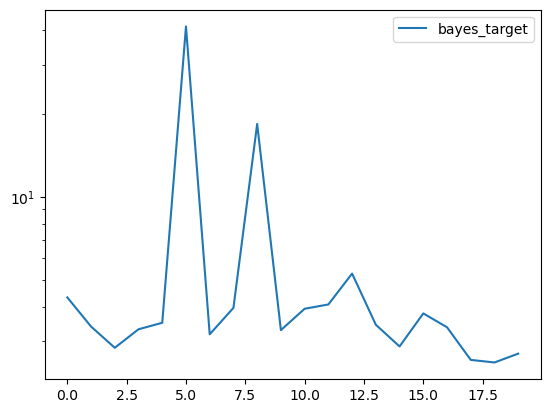

In [205]:
t0 = np.array([x['target'] for x in t_res])
df_t0 = pd.DataFrame(t0 * -1, columns=['bayes_target'])
ax = df_t0.plot()
ax.set_yscale('log')

In [20]:
# lightgbm_bayesian.optimizer.res

In [76]:
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
start = time.time()
k = lightgbm_bayesian.train_model(**t['params'])
debug_data = lightgbm_bayesian._debug_different_shifts
s1 = debug_data[-1]
df = s1['df']
# debug_data[1][4]
print('SMAPE ==', k)

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 81501, number of used features: 13
[LightGBM] [Info] Start training from score 2.573549
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 2.77224	valid_0's smape: 2.39289
[200]	training's smape: 2.26753	valid_0's smape: 1.91165
[300]	training's smape: 2.22374	valid_0's smape: 1.87464
[400]	training's smape: 2.18654	valid_0's smape: 1.84974
Did not meet early stopping. Best iteration is:
[499]	training's smape: 2.16638	valid_0's smape: 1.83533


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 78358, number of used features: 13
[LightGBM] [Info] Start training from score 2.574177
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 3.58429	valid_0's smape: 3.02534
[200]	training's smape: 3.18112	valid_0's smape: 2.63697
[300]	training's smape: 3.11848	valid_0's smape: 2.60239
[400]	training's smape: 3.0839	valid_0's smape: 2.58759
Did not meet early stopping. Best iteration is:
[499]	training's smape: 3.05675	valid_0's smape: 2.57786


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 78358, number of used features: 13
[LightGBM] [Info] Start training from score 2.575107
Training until validation scores don't improve for 100 rounds
[100]	training's smape: 4.32641	valid_0's smape: 3.50006
[200]	training's smape: 3.98357	valid_0's smape: 3.1811
[300]	training's smape: 3.91306	valid_0's smape: 3.15469
[400]	training's smape: 3.8703	valid_0's smape: 3.14373
Did not meet early stopping. Best iteration is:
[499]	training's smape: 3.83309	valid_0's smape: 3.13312
SMAPE == -2.515437228770372


In [93]:
t['params']

{'colsample_bytree': 0.9962962716916841,
 'drop_na': 0.10094417207908646,
 'learning_rate': 0.05654968682763671,
 'median_hh_inc': 0.7084469324759933,
 'num_iterations': 499.65441405582885,
 'num_leaves': 16.457638174778847,
 'outlier_multiplier': 3.1102504445298265,
 'pct_bb': 0.23727112238560366,
 'pct_college': 0.9366995017086428,
 'pct_foreign_born': 0.4662059709876668,
 'pct_it_workers': 0.9830058860677721,
 'reg_alpha': 6.244770062494906,
 'reg_lambda': 8.39114631864376,
 'shift_in_months': 0.13527368740205548,
 'state': 0.6249796875027976,
 'subsample': 0.13870717186706366,
 'target_mean_rolling_1': 9.441813647420823,
 'target_mean_rolling_2': 5.930066541458901,
 'target_mean_rolling_3': 8.950738188464006,
 'target_mean_rolling_4': 1.8399431833280677,
 'target_shift_1': 4.741791998979501,
 'target_shift_2': 0.029163025045000346,
 'target_shift_3': 6.89901942225319,
 'target_shift_4': 1.3942615381529655}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

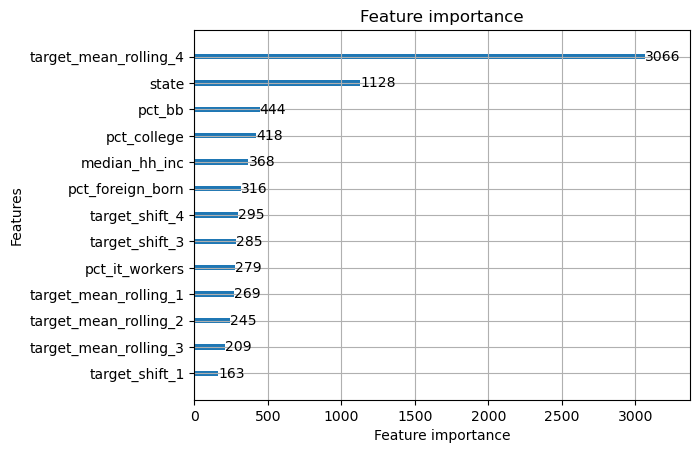

In [92]:
lgb.plot_importance(debug_data[-1]["gbm"], max_num_features=20)

In [77]:
data_eval = lightgbm_bayesian.per_case_error(-1)

<Axes: >

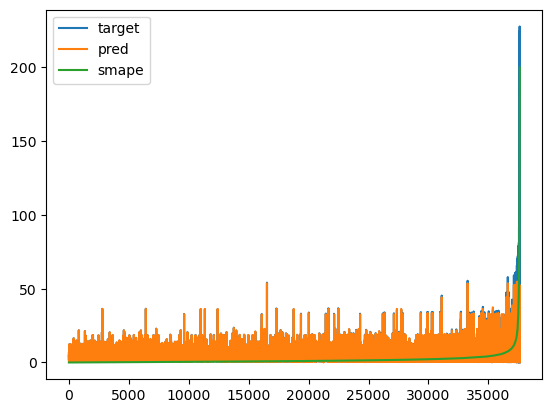

In [78]:
data_eval[['target', 'pred', 'smape']].sort_values('smape').reset_index(drop=True).plot()

In [79]:
s1.keys()

dict_keys(['lgb_train_data', 'lgb_train_label', 'lgb_eval_data', 'lgb_eval_label', 'df', 'cat_f', 'features', 'pred_eval', 'gbm'])

In [80]:
s1['lgb_eval_data'].loc[25:25]

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4,state


In [81]:
s1['df'].loc[25:25]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4
25,1001_2021-09-01,1001,Autauga County,Alabama,2021-09-01,3.186722,1344,2021,58731.0,80.6,16.1,2.3,0.7,9,3.20332,-1,3.165382,3.213278,3.19265,3.186722,3.22703,3.144043,3.219917


In [82]:
data_eval.sort_values('smape').tail(50)['cfips'].value_counts()

56033    12
32510    12
28055    12
51121     2
16021     2
12001     2
41023     2
8031      1
51043     1
20065     1
38087     1
15005     1
29063     1
Name: cfips, dtype: int64

<Axes: xlabel='first_day_of_month'>

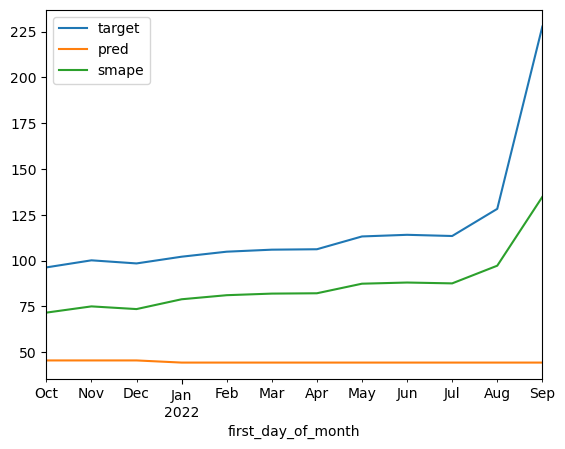

In [86]:
data_eval[data_eval['cfips'] == 56033].set_index('first_day_of_month')[['target', 'pred', 'smape']].plot()

In [87]:
data_eval[data_eval['cfips'] == 56033]

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4,state,target,pred,smape,row_id,cfips,first_day_of_month
122018,60807.0,82.9,16.5,2.0,1.5,-1,86.328140,89.622004,87.103970,92.220726,86.770164,82.235069,90.077621,Wyoming,96.304420,45.518298,71.619164,56033_2021-10-01,56033,2021-10-01
122019,60807.0,82.9,16.5,2.0,1.5,-1,88.126243,91.528856,88.809378,96.304420,88.099052,83.825516,92.220726,Wyoming,100.164528,45.518298,75.020826,56033_2021-11-01,56033,2021-11-01
122020,60807.0,82.9,16.5,2.0,1.5,-1,90.071062,93.941951,91.050561,100.164530,90.942459,86.770164,96.304420,Wyoming,98.470734,45.518298,73.550652,56033_2021-12-01,56033,2021-12-01
122021,59380.0,82.8,16.8,2.5,1.8,-1,91.875025,95.447606,92.881213,98.470734,90.077621,88.099052,100.164530,Wyoming,102.143494,44.346324,78.909471,56033_2022-01-01,56033,2022-01-01
122022,59380.0,82.8,16.8,2.5,1.8,-1,93.910355,97.860780,94.802879,102.143490,92.220726,90.942459,98.470734,Wyoming,104.880287,44.346324,81.130253,56033_2022-02-01,56033,2022-02-01
122023,59380.0,82.8,16.8,2.5,1.8,-1,95.922591,100.392693,96.900534,104.880290,96.304420,90.077621,102.143490,Wyoming,105.979187,44.346324,81.999207,56033_2022-03-01,56033,2022-03-01
122024,59380.0,82.8,16.8,2.5,1.8,-1,97.909273,102.327647,98.780125,105.979190,100.164530,92.220726,104.880290,Wyoming,106.209000,44.346324,82.179327,56033_2022-04-01,56033,2022-04-01
122025,59380.0,82.8,16.8,2.5,1.8,-1,99.605556,103.536541,100.796547,106.209000,98.470734,96.304420,105.979190,Wyoming,113.199348,44.346324,87.407066,56033_2022-05-01,56033,2022-05-01
122026,59380.0,82.8,16.8,2.5,1.8,-1,102.174637,106.482264,103.418876,113.199350,102.143490,100.164530,106.209000,Wyoming,114.093513,44.346324,88.042491,56033_2022-06-01,56033,2022-06-01
122027,59380.0,82.8,16.8,2.5,1.8,-1,104.604946,108.872268,105.642512,114.093510,104.880290,98.470734,113.199350,Wyoming,113.441689,44.346324,87.579992,56033_2022-07-01,56033,2022-07-01


In [ ]:
df[df['cfips'] == 56033]

In [65]:
idx = df[df['row_id'] == '16021_2022-09-01'].index[0]
offset = 3
df.iloc[idx-offset: idx+offset]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4
22409,16051_2021-07-01,16051,Jefferson County,Idaho,2021-07-01,5.180716,979,2021,63048.0,86.4,17.8,3.8,1.6,7,5.074880,-1,5.327172,5.144732,5.270012,5.180716,5.090755,5.609356,5.154257
22410,16051_2021-08-01,16051,Jefferson County,Idaho,2021-08-01,5.074880,959,2021,63048.0,86.4,17.8,3.8,1.6,8,5.085464,-1,5.248331,5.141557,5.183362,5.074880,5.143673,5.059004,5.180716
22411,16051_2021-09-01,16051,Jefferson County,Idaho,2021-09-01,5.085464,961,2021,63048.0,86.4,17.8,3.8,1.6,9,5.080172,-1,5.172485,5.129915,5.117876,5.085464,5.154257,5.090755,5.074880
22412,16051_2021-10-01,16051,Jefferson County,Idaho,2021-10-01,5.080172,960,2021,63048.0,86.4,17.8,3.8,1.6,10,5.138382,-1,5.113687,5.115098,5.120522,5.080172,5.154257,5.143673,5.085464
22413,16051_2021-11-01,16051,Jefferson County,Idaho,2021-11-01,5.138382,971,2021,63048.0,86.4,17.8,3.8,1.6,11,5.154257,-1,5.122506,5.111923,5.126475,5.138382,5.180716,5.154257,5.080172
22414,16051_2021-12-01,16051,Jefferson County,Idaho,2021-12-01,5.154257,974,2021,63048.0,86.4,17.8,3.8,1.6,12,5.026727,-1,5.129562,5.106631,5.127798,5.154257,5.074880,5.154257,5.138382


In [213]:
data_eval.iloc[idx-offset: idx+offset]

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4,state,target,pred,smape,row_id,cfips
70974,33873.0,68.7,13.4,4.3,1.0,-1,4.120255,4.003453,4.092920,3.949498,3.981871,4.263566,4.046617,New Mexico,3.960289,3.976260,0.402452,35051_2022-05-01,35051
70975,33873.0,68.7,13.4,4.3,1.0,-1,4.078184,3.999137,4.048282,3.960289,4.025035,4.145134,3.949498,New Mexico,3.960289,3.976260,0.402452,35051_2022-06-01,35051
70976,33873.0,68.7,13.4,4.3,1.0,-1,4.038505,3.986188,4.010372,3.960289,4.014244,3.981871,3.960289,New Mexico,3.873961,3.973734,2.542714,35051_2022-07-01,35051
70977,33873.0,68.7,13.4,4.3,1.0,-1,3.995215,3.958131,3.976476,3.873961,4.046617,4.025035,3.960289,New Mexico,3.895543,3.883353,0.313410,35051_2022-08-01,35051
70978,33873.0,68.7,13.4,4.3,1.0,-1,3.967483,3.927916,3.965685,3.895543,3.949498,4.014244,3.873961,New Mexico,3.927916,3.904009,0.610518,35051_2022-09-01,35051
71006,42083.0,55.3,12.0,6.9,1.0,-1,2.947027,2.942758,2.950442,2.958125,2.919708,2.981176,2.965809,New Mexico,2.973492,2.943311,1.020186,35053_2021-10-01,35053


In [147]:
s1.keys()

dict_keys(['lgb_train', 'lgb_eval', 'df', 'cat_f', 'features', 'pred_eval', 'gbm'])

In [148]:
t4 = pd.DataFrame(s1['lgb_eval'].label, columns=['target'])

In [149]:
t4[t4['target'] == 0].shape

(9414, 1)

In [150]:
df_train[df_train['microbusiness_density'] == 0].shape

(26, 14)

In [94]:
df = s1['df']
df[df['microbusiness_density'] == 0].shape

(26, 22)

In [96]:
df[df['shifted_microbusiness_density'] == 0].shape

(26, 22)

In [153]:
df[df['row_id'].isin(data_eval[data_eval['target'] == 0]['row_id'])]['shifted_microbusiness_density'].shape

(3146,)

In [85]:
s1 = debug_data[-1]
s1.keys()

dict_keys(['lgb_train', 'lgb_eval', 'df', 'cat_f', 'features', 'pred_eval', 'gbm'])

In [74]:
data_eval

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_4,state,target,pred,smape
27,58731.0,80.6,16.1,2.3,0.7,-1,3.211915,3.204373,3.200948,3.202134,3.210433,3.186722,Alabama,3.286307,3.194451,2.834735
28,58731.0,80.6,16.1,2.3,0.7,-1,3.219621,3.220181,3.286307,3.243628,3.219917,3.203320,Alabama,3.296781,3.306047,0.280663
29,57982.0,82.7,16.7,2.3,0.6,-1,3.228339,3.228194,3.296781,3.291544,3.186722,3.200948,Alabama,3.334431,3.298029,1.097718
30,57982.0,82.7,16.7,2.3,0.6,-1,3.242357,3.240127,3.334431,3.315606,3.203320,3.286307,Alabama,3.336785,3.322074,0.441839
31,57982.0,82.7,16.7,2.3,0.6,-1,3.258151,3.252849,3.336785,3.335608,3.200948,3.296781,Alabama,3.372082,3.325531,1.390080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,53333.0,79.7,12.7,2.3,0.0,-1,1.774704,1.763132,1.803249,1.803249,1.749688,1.767542,Wyoming,1.803249,1.811077,0.433115
122261,53333.0,79.7,12.7,2.3,0.0,-1,1.780063,1.777876,1.803249,1.803249,1.767542,1.803249,Wyoming,1.785396,1.812892,1.528324
122262,53333.0,79.7,12.7,2.3,0.0,-1,1.778700,1.780656,1.785395,1.794322,1.767542,1.803249,Wyoming,1.785396,1.791593,0.346520
122263,53333.0,79.7,12.7,2.3,0.0,-1,1.783164,1.779444,1.785395,1.785395,1.803249,1.803249,Wyoming,1.785396,1.789224,0.214190


In [72]:
t1.mean()

18.286972939158105

In [58]:
data_eval_pred.shape

(37620,)

In [30]:
type(debug_data[-1]['lgb_train'].label)

numpy.ndarray

In [100]:
k

-35.328560364364726

In [53]:
# lightgbm_bayesian._debug_different_shifts[-1]['lgb_eval'].data

In [54]:
# lightgbm_bayesian.optimizer.max

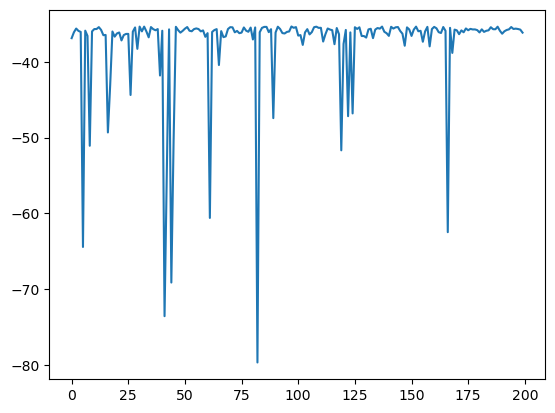

In [84]:
t0 = [x['target'] for x in lightgbm_bayesian.optimizer.res]
plt.plot(t0)

In [56]:
# lightgbm_bayesian.optimizer.max

In [57]:
# lightgbm_bayesian.optimizer.max

In [58]:
params = {
    "colsample_bytree": 0.915899949299061,
    "drop_na": 0.7740473326986388,
    "learning_rate": 0.17324112449403456,
    "median_hh_inc": 0.08110138998799676,
    "num_iterations": 436.87911284311696,
    "num_leaves": 27.06224350623956,
    "pct_bb": 0.13248763475798297,
    "pct_college": 0.05342718178682526,
    "pct_foreign_born": 0.7255943642105788,
    "pct_it_workers": 0.011427458625031028,
    "reg_alpha": 7.705807485027762,
    "reg_lambda": 1.4694664540037505,
    "shift_in_months": 0.07952208258675575,
    "state": 0.08960303423860538,
    "subsample": 0.704843026618523,
    "target_mean_rolling_1": 2.4536720985284477,
    "target_mean_rolling_2": 4.205394666800984,
    "target_mean_rolling_3": 5.573687913239169,
    "target_mean_rolling_4": 8.605511738287937,
    "target_mean_rolling_5": 0.7270442627113283,
    "target_mean_rolling_7": 0.27032790523871464,
    "target_shift_1": 1.314827992911276,
    "target_shift_2": 0.5537432042119794,
    "target_shift_3": 3.015986344809425,
    "target_shift_4": 2.6211814923967824,
}
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
k = lightgbm_bayesian.train_model(**params, return_data=False)
debug_data = lightgbm_bayesian._debug_different_shifts
# debug_data[1][4]

New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 84561, number of used features: 13
[LightGBM] [Info] Start training from score 2.571979
Training until validation scores don't improve for 100 rounds
[100]	valid_0's smape: 18.7865
[200]	valid_0's smape: 18.7485
[300]	valid_0's smape: 18.7491
Early stopping, best iteration is:
[222]	valid_0's smape: 18.7436


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 84561, number of used features: 13
[LightGBM] [Info] Start training from score 2.573102
Training until validation scores don't improve for 100 rounds
[100]	valid_0's smape: 35.8037
[200]	valid_0's smape: 35.7818
Early stopping, best iteration is:
[152]	valid_0's smape: 35.7692


New categorical_feature is ['state']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 84561, number of used features: 13
[LightGBM] [Info] Start training from score 2.574047
Training until validation scores don't improve for 100 rounds
[100]	valid_0's smape: 52.6816
[200]	valid_0's smape: 52.656
[300]	valid_0's smape: 52.6608
Early stopping, best iteration is:
[211]	valid_0's smape: 52.6509


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

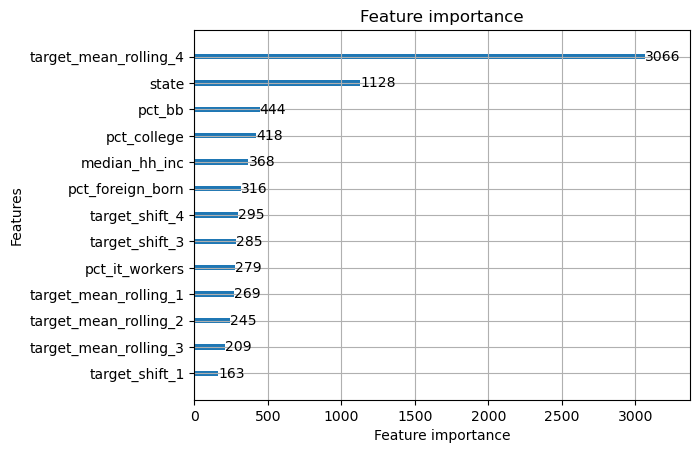

In [91]:
lgb.plot_importance(debug_data[-1]["gbm"], max_num_features=20)

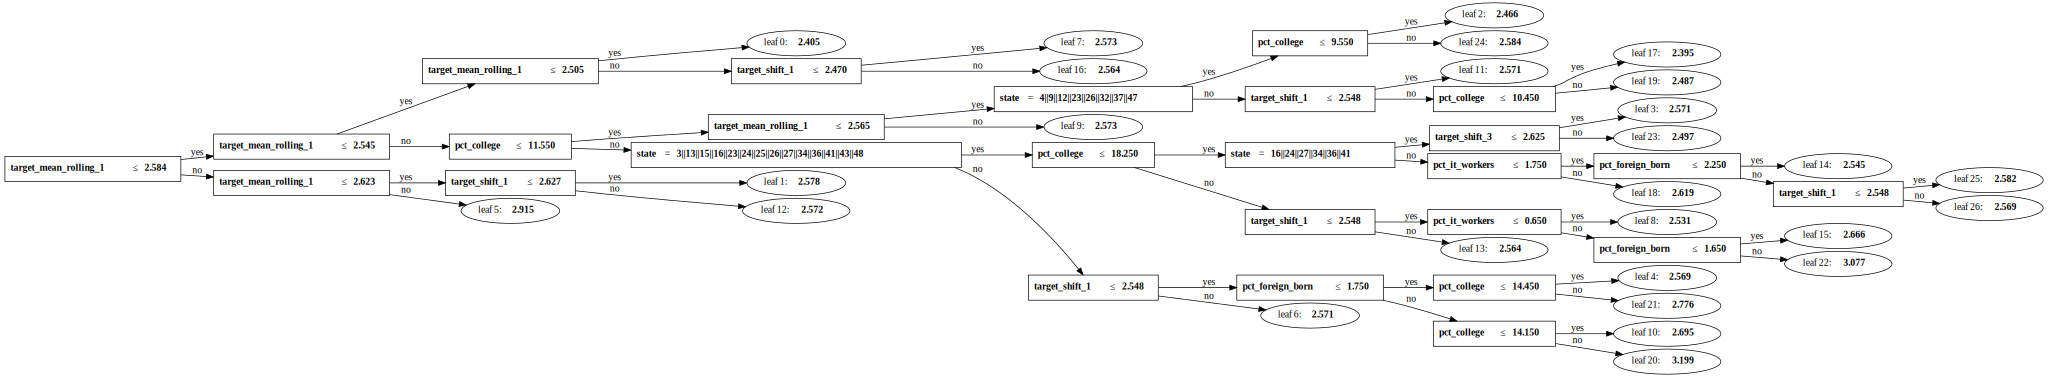

In [60]:
lgb.create_tree_digraph(debug_data[-1]["gbm"])

In [61]:
k

-35.72123873919826

In [62]:
# def smape(pred, eval_data):
#     A = eval_data.label
#     F = pred

#     value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
#     return "smape", value, False

In [47]:
debug_data = lightgbm_bayesian._debug_different_shifts
all_pred = []
all_eval = []

for values in debug_data.values():
    all_eval.extend(list(values["lgb_eval"].label))
    all_pred.extend(list(values["pred_eval"]))

all_pred = np.array(all_pred)

myobject = SimpleNamespace()  # myobject = {}
myobject.label = np.array(all_eval)
all_eval = myobject

In [50]:
smape(all_pred, all_eval)

('smape', 35.328560364364726, False)

In [48]:
all_eval.label

array([3.286307 , 3.2967808, 3.3344314, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [49]:
all_pred

array([3.19445095, 3.30604668, 3.29802857, ..., 1.8326265 , 1.8326265 ,
       1.8326265 ])

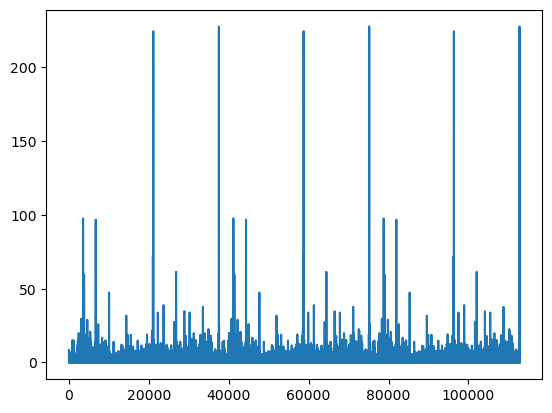

In [66]:
plt.plot(all_eval.label)

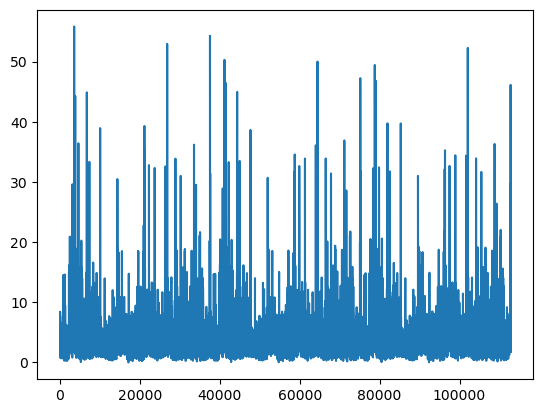

In [67]:
plt.plot(all_pred)

In [42]:
smape(values["pred_eval"], values["lgb_eval"])

('smape', 52.65171470382744, False)

In [39]:
all_eval

namespace(label=array([3.2033195, 3.2009485, 3.286307 , ..., 1.8032495, 1.8032495,
                       1.8032495], dtype=float32))

In [40]:
smape(all_pred, all_eval)

('smape', 1.6109784840580934, False)

In [41]:
values["lgb_eval"].label

array([3.219917 , 3.186722 , 3.2033195, ..., 1.8032495, 1.8032495,
       1.8032495], dtype=float32)

In [42]:
debug_data = lightgbm_bayesian._debug_different_shifts

In [43]:
debug_data[1].keys()

dict_keys(['lgb_train', 'lgb_eval', 'df', 'cat_f', 'features', 'pred_eval'])

In [44]:
debug_data[1]["pred_eval"]

array([3.20325658, 3.2034845 , 3.28688608, ..., 1.7993914 , 1.78546538,
       1.78580036])

In [48]:
set(debug_data[1]["features"]) - bounds.keys()

{'median_hh_inc',
 'pct_bb',
 'pct_college',
 'pct_foreign_born',
 'pct_it_workers',
 'shift_in_months',
 'state'}

In [49]:
set(bounds.keys())

{'colsample_bytree',
 'drop_na',
 'include_state',
 'learning_rate',
 'num_iterations',
 'num_leaves',
 'reg_alpha',
 'reg_lambda',
 'subsample',
 'target_mean_rolling_1',
 'target_mean_rolling_2',
 'target_mean_rolling_3',
 'target_mean_rolling_4',
 'target_shift_1',
 'target_shift_2',
 'target_shift_3',
 'target_shift_4'}

In [ ]:
# params = {'colsample_bytree': 0.8353298922653473, 'drop_na': 0.5528400601423047, 'learning_rate': 0.3953127733931253, 'num_iterations': 806.8866721638205, 'num_leaves': 88.75593961360586, 'reg_alpha': 6.014914792272201, 'reg_lambda': 3.730587337632093, 'subsample': 0.2970806689918379, 'target_shift_1': 1.9084284045082367, 'target_shift_2': 9.824773888856306, 'target_shift_3': 0.871530237861694, 'target_shift_4': 6.211016130203594}
# lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
# for k in lightgbm_bayesian.train_model(**params):
#     print('-------------------')

In [16]:
params = {
    "colsample_bytree": 0.8353298922653473,
    "drop_na": 0.5528400601423047,
    "learning_rate": 0.3953127733931253,
    "num_iterations": 806.8866721638205,
    "num_leaves": 88.75593961360586,
    "reg_alpha": 6.014914792272201,
    "reg_lambda": 3.730587337632093,
    "subsample": 0.2970806689918379,
    "target_shift_1": 1.9084284045082367,
    "target_shift_2": 9.824773888856306,
    "target_shift_3": 0.871530237861694,
    "target_shift_4": 6.211016130203594,
}
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
k = lightgbm_bayesian.train_model(**params, return_data=False)
debug_data = lightgbm_bayesian.prepare_data._debug_different_shifts
debug_data[1][4]

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's smape: 0.721259


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's smape: 1.83812


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's smape: 2.27356


In [17]:
debug_data = lightgbm_bayesian.prepare_data._debug_different_shifts
debug_data[1][4]

In [18]:
debug_data[1][4]

['median_hh_inc',
 'pct_bb',
 'pct_college',
 'pct_foreign_born',
 'pct_it_workers',
 'shift_in_months',
 'target_shift__1',
 'target_shift__9',
 'target_shift__6',
 'state']

In [19]:
t1 = debug_data[2][2]
t1[t1["microbusiness_density"].isna()]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_shift__1,target_shift__9,target_shift__6


In [29]:
debug_data[1][1].data

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_shift__1,target_shift__9,target_shift__6,state
27,58731.0,80.6,16.1,2.3,0.7,1,3.203320,3.106106,3.227030,Alabama
28,58731.0,80.6,16.1,2.3,0.7,1,3.200948,3.144043,3.222288,Alabama
29,57982.0,82.7,16.7,2.3,0.6,1,3.286307,3.224659,3.210433,Alabama
30,57982.0,82.7,16.7,2.3,0.6,1,3.296781,3.227030,3.219917,Alabama
31,57982.0,82.7,16.7,2.3,0.6,1,3.334431,3.222288,3.186722,Alabama
...,...,...,...,...,...,...,...,...,...,...
122260,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.688522,1.796300,Wyoming
122261,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.670559,1.749688,Wyoming
122262,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.760374,1.749688,Wyoming
122263,53333.0,79.7,12.7,2.3,0.0,1,1.785395,1.796300,1.767542,Wyoming


In [35]:
debug_data[3][1].data

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_shift__1,target_shift__9,target_shift__6,state
27,58731.0,80.6,16.1,2.3,0.7,3,3.203320,3.106106,3.227030,Alabama
28,58731.0,80.6,16.1,2.3,0.7,3,3.200948,3.144043,3.222288,Alabama
29,57982.0,82.7,16.7,2.3,0.6,3,3.286307,3.224659,3.210433,Alabama
30,57982.0,82.7,16.7,2.3,0.6,3,3.296781,3.227030,3.219917,Alabama
31,57982.0,82.7,16.7,2.3,0.6,3,3.334431,3.222288,3.186722,Alabama
...,...,...,...,...,...,...,...,...,...,...
122260,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.688522,1.796300,Wyoming
122261,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.670559,1.749688,Wyoming
122262,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.760374,1.749688,Wyoming
122263,53333.0,79.7,12.7,2.3,0.0,3,1.785395,1.796300,1.767542,Wyoming


In [39]:
debug_data[1][1].label[-10:]

array([1.7962996, 1.7496876, 1.7496876, 1.7675415, 1.7675415, 1.8032495,
       1.8032495, 1.8032495, 1.7853955, 1.7853955], dtype=float32)

In [40]:
debug_data[3][1].label[-10:]

array([1.6705587, 1.7603736, 1.7962996, 1.7496876, 1.7496876, 1.7675415,
       1.7675415, 1.8032495, 1.8032495, 1.8032495], dtype=float32)

In [50]:
idx = debug_data[3][1].data[-10:].index

In [51]:
df = debug_data[3][2]
df[df.index.isin(idx)]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_shift__1,target_shift__9,target_shift__6
122255,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98,2022,53333.0,79.7,12.7,2.3,0.0,1,1.670559,3,1.796300,1.724448,1.652596
122256,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98,2022,53333.0,79.7,12.7,2.3,0.0,2,1.760374,3,1.749688,1.688522,1.670559
122257,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99,2022,53333.0,79.7,12.7,2.3,0.0,3,1.796300,3,1.749688,1.652596,1.688522
122258,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99,2022,53333.0,79.7,12.7,2.3,0.0,4,1.749688,3,1.767542,1.652596,1.670559
122259,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,5,1.749688,3,1.767542,1.670559,1.760374
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,6,1.767542,3,1.803249,1.688522,1.796300
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,7,1.767542,3,1.803249,1.670559,1.749688
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,8,1.803249,3,1.803249,1.760374,1.749688
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,9,1.803249,3,1.785395,1.796300,1.767542
122264,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,10,1.803249,3,1.785395,1.749688,1.767542


In [47]:
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_shift__1,target_shift__9,target_shift__6
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,55317.0,76.6,14.5,2.1,1.3,8,NaN,3,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,55317.0,76.6,14.5,2.1,1.3,9,NaN,3,3.007682,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,55317.0,76.6,14.5,2.1,1.3,10,NaN,3,2.884870,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,11,3.007682,3,3.055843,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,12,2.884870,3,2.993233,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,6,1.767542,3,1.803249,1.688522,1.796300
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,7,1.767542,3,1.803249,1.670559,1.749688
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,8,1.803249,3,1.803249,1.760374,1.749688
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,9,1.803249,3,1.785395,1.796300,1.767542


In [41]:
debug_data[1][1].data[-10:]

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_shift__1,target_shift__9,target_shift__6,state
122255,53333.0,79.7,12.7,2.3,0.0,1,1.796300,1.724448,1.652596,Wyoming
122256,53333.0,79.7,12.7,2.3,0.0,1,1.749688,1.688522,1.670559,Wyoming
122257,53333.0,79.7,12.7,2.3,0.0,1,1.749688,1.652596,1.688522,Wyoming
122258,53333.0,79.7,12.7,2.3,0.0,1,1.767542,1.652596,1.670559,Wyoming
122259,53333.0,79.7,12.7,2.3,0.0,1,1.767542,1.670559,1.760374,Wyoming
122260,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.688522,1.796300,Wyoming
122261,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.670559,1.749688,Wyoming
122262,53333.0,79.7,12.7,2.3,0.0,1,1.803249,1.760374,1.749688,Wyoming
122263,53333.0,79.7,12.7,2.3,0.0,1,1.785395,1.796300,1.767542,Wyoming
122264,53333.0,79.7,12.7,2.3,0.0,1,1.785395,1.749688,1.767542,Wyoming


In [42]:
debug_data[3][1].data[-10:]

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,shift_in_months,target_shift__1,target_shift__9,target_shift__6,state
122255,53333.0,79.7,12.7,2.3,0.0,3,1.796300,1.724448,1.652596,Wyoming
122256,53333.0,79.7,12.7,2.3,0.0,3,1.749688,1.688522,1.670559,Wyoming
122257,53333.0,79.7,12.7,2.3,0.0,3,1.749688,1.652596,1.688522,Wyoming
122258,53333.0,79.7,12.7,2.3,0.0,3,1.767542,1.652596,1.670559,Wyoming
122259,53333.0,79.7,12.7,2.3,0.0,3,1.767542,1.670559,1.760374,Wyoming
122260,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.688522,1.796300,Wyoming
122261,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.670559,1.749688,Wyoming
122262,53333.0,79.7,12.7,2.3,0.0,3,1.803249,1.760374,1.749688,Wyoming
122263,53333.0,79.7,12.7,2.3,0.0,3,1.785395,1.796300,1.767542,Wyoming
122264,53333.0,79.7,12.7,2.3,0.0,3,1.785395,1.749688,1.767542,Wyoming


In [25]:
t0

,0
0,1
1,2
2,3
3,3


In [27]:
t0.shift().dropna()

,0
1,1.0
2,2.0
3,3.0


In [ ]:
k

In [ ]:
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
lightgbm_bayesian.optimize(init_points=10, n_iter=10)

In [31]:
d = lightgbm_bayesian.prepare_data._debug_different_shifts
pr = lightgbm_bayesian.prepare_data
# d.keys()

In [33]:
d.keys()

dict_keys([-1, -2, -3])

In [40]:
df = d[-1][2]
# t = df.copy()
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,shifted_microbusiness_density,shift_in_months,target_mean_rolling_1,target_mean_rolling_2,target_mean_rolling_3,target_mean_rolling_4,target_shift_1,target_shift_3,target_shift_4
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,55317.0,76.6,14.5,2.1,1.3,8,2.884870,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,55317.0,76.6,14.5,2.1,1.3,9,3.055843,-1,2.946276,NaN,NaN,NaN,3.007682,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,55317.0,76.6,14.5,2.1,1.3,10,2.993233,-1,2.970357,NaN,NaN,NaN,2.884870,NaN,3.007682
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,11,2.993233,-1,3.024538,2.985407,NaN,NaN,3.055843,3.007682,2.884870
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,12,2.969090,-1,2.993233,2.981795,2.986972,NaN,2.993233,2.884870,3.055843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,6,1.803249,-1,1.803249,1.785395,1.778254,1.774704,1.803249,1.767542,1.767542
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,7,1.785395,-1,1.803249,1.794322,1.788966,1.780063,1.803249,1.767542,1.803249
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,8,1.785395,-1,1.794322,1.798786,1.792537,1.778700,1.803249,1.803249,1.803249
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,9,1.785395,-1,1.785395,1.794322,1.796108,1.783164,1.785395,1.803249,1.803249


In [30]:
# debug_data = lightgbm_bayesian.prepare_data._debug_different_shifts
df[pr._col_target] = (
    df.sort_values([pr._col_cfips, pr._col_first_day_of_month])
    .groupby(pr._col_cfips)[pr._col_target]
    .shift(1)
    .dropna()
)

NameError: name 'df' is not defined

In [ ]:
df

In [ ]:
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
lightgbm_bayesian.optimize()

In [ ]:
k

In [ ]:
params

In [ ]:
lightgbm_bayesian.optimizer.max

In [ ]:
t = pd.concat(
    [
        pd.DataFrame.from_dict(lightgbm_bayesian.optimizer.res),
        pd.DataFrame.from_dict([x["params"] for x in lightgbm_bayesian.optimizer.res]),
    ],
    axis=1,
)
t = t.drop(columns=["params"])

t["include_state_bool"] = 0
idx = t[t["include_state"] > 0.5].index
t.loc[idx, "include_state_bool"] = 1

r = []
for col in t.columns[1:]:
    v = t.groupby(col)["target"].agg("mean").diff().dropna().values[0]
    r.append({"col": col, "diff": v})

pd.DataFrame(r)

In [ ]:
[x["params"] for x in lightgbm_bayesian.optimizer.res]

In [ ]:
lgb_train, lgb_eval, df, features = lightgbm_bayesian._train_model(
    **lightgbm_bayesian.optimizer.max["params"], return_data=True
)

In [ ]:
df[[x for x in df.columns if "target" in x] + ["microbusiness_density"]].head(10)

In [ ]:
lgb_train.data

In [ ]:
t = {
    "colsample_bytree": 0.5939321535345923,
    "drop_na": 0.7151893663724195,
    "learning_rate": 0.3053540542751055,
    "num_iterations": 567.639023847052,
    "num_leaves": 45.24720593719595,
    "reg_alpha": 6.458941130666561,
    "reg_lambda": 4.375872112626925,
    "subsample": 0.9025957007038717,
    "target_shift_1": 9.636627605010293,
    "target_shift_2": 3.8344151882577773,
    "target_shift_3": 7.917250380826646,
    "target_shift_4": 5.288949197529044,
}

In [ ]:
t

In [ ]:
t["target_shift_6"] = 7.5

In [ ]:
d = {k: v for k, v in t.items() if k.startswith("target_shift_")}
f_data = pd.DataFrame.from_dict(d, orient="index", columns=["orig_val"])
f_data["int_val"] = f_data["orig_val"].astype(int)
f_data.drop_duplicates(subset=["int_val"]).drop(columns=["orig_val"]).to_dict()[
    "int_val"
]

In [ ]:
lightgbm_bayesian.optimizer.max

In [ ]:
# args = {
#     "colsample_bytree": 0.8353298922653473,
#     "drop_na": 0.5528400601423047,
#     "learning_rate": 0.3953127733931253,
#     "num_iterations": 806.8866721638205,
#     "num_leaves": 88.75593961360586,
#     "reg_alpha": 6.014914792272201,
#     "reg_lambda": 3.730587337632093,
#     "subsample": 0.2970806689918379,
#     "target_shift_1": 1.9084284045082367,
#     "target_shift_2": 9.824773888856306,
#     "target_shift_3": 0.871530237861694,
#     "target_shift_4": 6.211016130203594,
#     # "target_rolling_1": 0,
#     # "target_rolling_2": 0,
#     # "target_rolling_3": 0,
#     # "target_rolling_4": 0,
#     "shift": 0,
# }
# (lgb_train, lgb_eval, df, cat_f, features) = prepare_data.prepare_data_for_model(args)

#### Bayesian

In [ ]:
# Define the bounds for the hyperparameters
bounds = {
    "num_leaves": (5, 100),
    "num_iterations": (50, 1000),
    "learning_rate": (0.01, 0.5),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 10),
    "reg_lambda": (0, 10),
    # "target_rolling_1": (0, 20),
    # "target_rolling_2": (0, 20),
    # "target_rolling_3": (0, 20),
    # "target_rolling_4": (0, 20),
    "target_shift_1": (0, 10),
    "target_shift_2": (0, 10),
    "target_shift_3": (0, 10),
    "target_shift_4": (0, 10),
    "drop_na": (0, 1),
}

# Initialize the Bayesian Optimization
optimizer = BayesianOptimization(train_model, bounds, random_state=0)

# af = bayes.UtilityFunction('poi', kappa=100)
acquisition_function = bayes.UtilityFunction(kind="ei", xi=1e-4)

# Run the optimization
optimizer.maximize(
    # init_points=100, n_iter=100
    init_points=10,
    n_iter=10,
    acquisition_function=acquisition_function,
)

# Get the best hyperparameters
best_params = optimizer.max["params"]
print("Best hyperparameters: ", best_params)

In [39]:
optimizer.max

{'target': -1.795907479627544,
 'params': {'colsample_bytree': 0.8353298922653473,
  'drop_na': 0.5528400601423047,
  'learning_rate': 0.3953127733931253,
  'num_iterations': 806.8866721638205,
  'num_leaves': 88.75593961360586,
  'reg_alpha': 6.014914792272201,
  'reg_lambda': 3.730587337632093,
  'subsample': 0.2970806689918379,
  'target_shift_1': 1.9084284045082367,
  'target_shift_2': 9.824773888856306,
  'target_shift_3': 0.871530237861694,
  'target_shift_4': 6.211016130203594}}

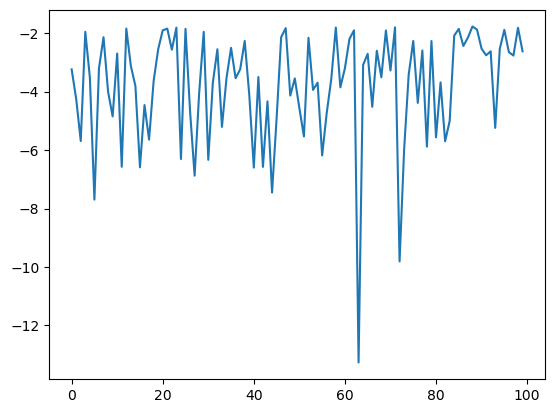

In [51]:
plt.plot(optimizer.space.target)

In [22]:
optimizer.max

{'target': -1.760021832882329,
 'params': {'colsample_bytree': 0.9926470506571945,
  'drop_na': 0.9493044811324699,
  'learning_rate': 0.13289512286071886,
  'num_iterations': 670.6793360790518,
  'num_leaves': 21.40639308352767,
  'reg_alpha': 1.8285286911054612,
  'reg_lambda': 1.2863879194485066,
  'subsample': 0.919283705163911,
  'target_shift_1': 9.008899825389719,
  'target_shift_2': 5.139411794860202,
  'target_shift_3': 3.8700569611353552,
  'target_shift_4': 1.8102240595765506}}

In [192]:
optimizer.max

{'target': -1.6410407836914596,
 'params': {'colsample_bytree': 1.0,
  'drop_na': 0.753755096557041,
  'learning_rate': 0.3,
  'num_iterations': 385.18088222307017,
  'num_leaves': 25.518657242596824,
  'reg_alpha': 2.0,
  'reg_lambda': 0.6667876537054737,
  'subsample': 1.0,
  'target_shift_1': 2.7205028639681834,
  'target_shift_2': 9.159457441010735,
  'target_shift_3': 1.4526929394139416,
  'target_shift_4': 3.1387566084934844}}

In [158]:
optimizer.max

{'target': -1.7054704431935428,
 'params': {'colsample_bytree': 0.9351785499385221,
  'drop_na': 0.8668609136593749,
  'learning_rate': 0.24668371815724682,
  'num_iterations': 915.8783315832242,
  'num_leaves': 11.908428818426234,
  'reg_alpha': 0.739047080279299,
  'reg_lambda': 0.7597878075720348,
  'subsample': 0.6044055298388022,
  'target_shift_1': 3.341091147713855,
  'target_shift_2': 1.4335834152019715,
  'target_shift_3': 0.09731233654650173,
  'target_shift_4': 1.9961119182895466}}

In [194]:
df_test["first_day_of_month"].unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

In [36]:
(lgb_train, lgb_eval, df, features) = train_model(
    **optimizer.max["params"], return_data=True
)

Some rows here will have ´NaN´. Maybe drop them?


## Results

In [ ]:
lgb.plot_importance(gbm, max_num_features=20)

In [ ]:
t = df_train.copy()
idx = y_train.index

cols = x_train.columns.difference(df_train.columns)
cols = x_train.columns.intersection(cols)
t[cols] = x_train[cols].copy()

t.loc[idx, "target"] = (y_train - target_const).values
t.loc[idx, "pred"] = gbm.predict(x_train) - target_const
t = t.loc[idx]
t["diff"] = abs(t["target"] - t["pred"])


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


t["relative"] = t["diff"] / t["pred"]

# Analyze

In [121]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)

In [125]:
dates = np.sort(df_train["first_day_of_month"].unique())
c = int(dates.shape[0] * 0.70)
dates_train = dates[:c]
dates_val = dates[c:]

In [127]:
dates_train.shape

(27,)

### Long/Lat

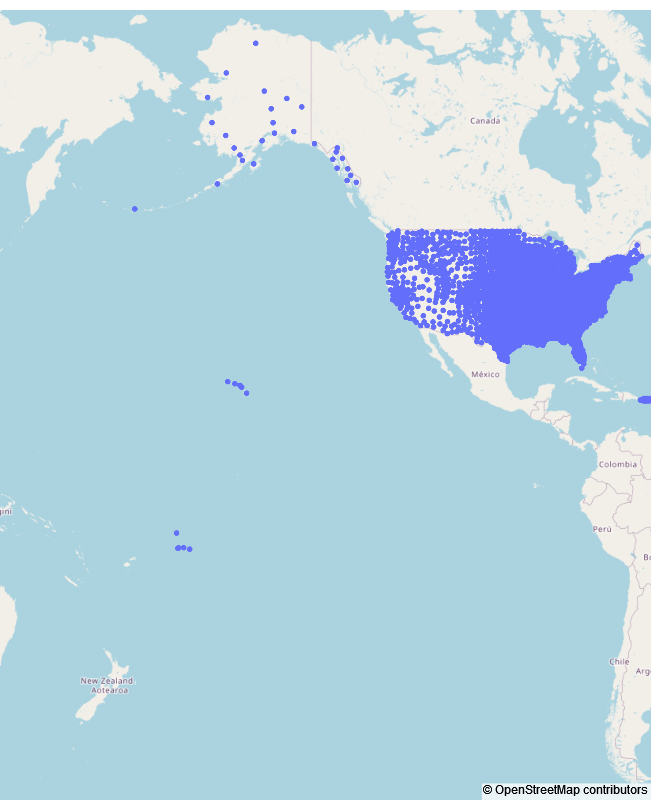

In [31]:
import plotly.express as px

color_scale = [(0, "orange"), (1, "red")]

fig = px.scatter_mapbox(
    df_boundaries,
    lat="INTPTLAT",
    lon="INTPTLON",
    color_continuous_scale=color_scale,
    zoom=8,
    height=800,
    width=800,
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

### Analyze

#### State corr

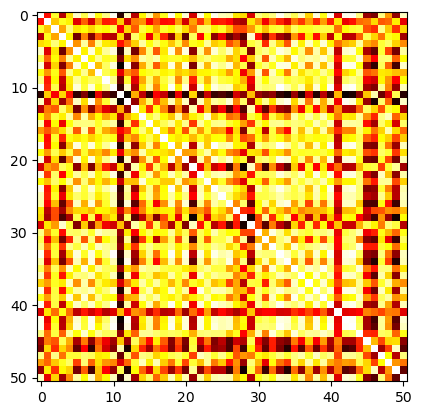

In [63]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)
t1 = t0.pivot_table("mean", "first_day_of_month", "state").sort_index().corr()
plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [64]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [65]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std"])

,mean,std
cluster,,
0,-0.883181,0.003564
1,-0.861992,0.002977
2,-0.824271,0.011028
3,-0.773983,0.014174
4,-0.720835,0.013591
5,-0.685720,0.006453
6,-0.342746,0.173984
7,0.560881,0.266506


In [75]:
t5.shape

(1275, 4)

In [76]:
corr_states = t5[abs(t5["corr"]) > 0.8]

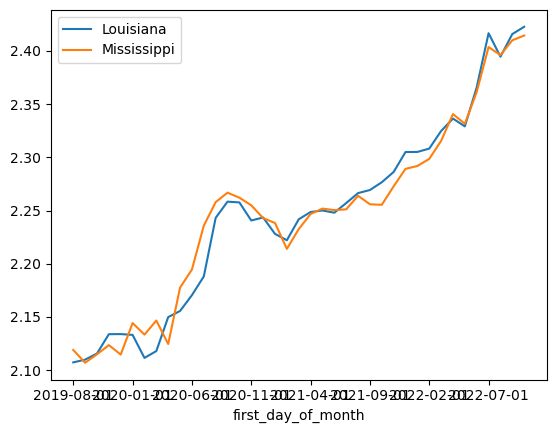

In [353]:
ax = (
    df_train[df_train["state"] == "Louisiana"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

t9 = (
    df_train[df_train["state"] == "Mississippi"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    + 0.55
)

t9.plot(ax=ax)

plt.legend(["Louisiana", "Mississippi"]);

In [77]:
corr_states = t5[abs(t5["corr"]) > 0.8]

#### State corr shifted

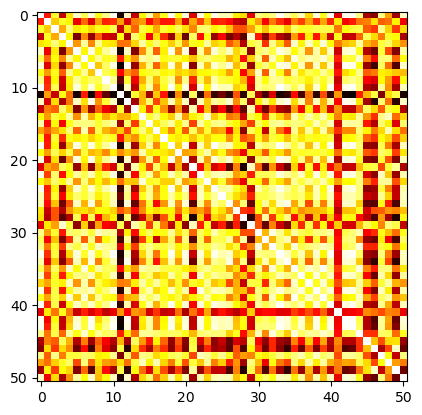

In [48]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)

state = "Hawaii"

t7 = t0.pivot_table("mean", "first_day_of_month", "state")
a = t7[state].shift(-6).copy()
a.index = t7.index
t7[state] = a

t1 = t7.sort_index().corr()

plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [49]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [50]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std", "count"])

,mean,std,count
cluster,,,
-1,-0.846966,0.091663,4
0,-0.899633,0.004823,3
1,-0.870264,0.008830,7
2,-0.820720,0.016026,13
3,-0.723982,0.015836,9
4,-0.682406,0.005995,4
5,-0.647259,0.013949,15
6,-0.319367,0.162856,245
7,0.557835,0.268067,975


In [52]:
t5[t5["state"] == state].sort_values("corr")

,state,other_state,corr,cluster
0,Hawaii,Texas,-0.932125,-1
4,Hawaii,Tennessee,-0.905163,0
12,Hawaii,North Carolina,-0.879889,1
14,Hawaii,Idaho,-0.876515,1
16,Hawaii,Wyoming,-0.868376,1
22,Hawaii,Louisiana,-0.859612,1
28,Hawaii,Montana,-0.835544,2
30,Hawaii,Maryland,-0.834484,2
32,Hawaii,Pennsylvania,-0.830167,2
34,Hawaii,Nevada,-0.827150,2


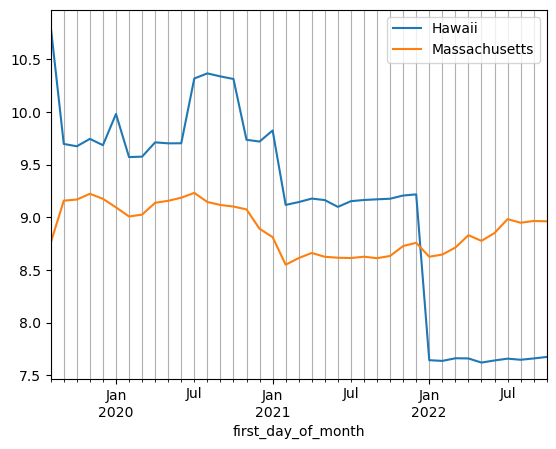

In [54]:
# ax = df_train[df_train["state"] == "Alabama"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot()

k = df_train[df_train["state"] == state].copy()
k["first_day_of_month"] = k["first_day_of_month"]  # - pd.DateOffset(months=6)

ax = (
    k.sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

other = "Massachusetts"
t9 = (
    df_train[df_train["state"] == other]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
)

t9.plot(ax=ax)

plt.legend([state, other])

ax.grid("on", which="minor", axis="x")
ax.grid("off", which="major", axis="x")

#### Count up/down

In [198]:
def ups_downs(df_train):
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

In [199]:
df_ups_downs = ups_downs(df_train)

In [200]:
df_ups_downs

,row_id,microbusiness_shift_bool_over_pct
0,1001_2019-08-01,NaN
1,1001_2019-09-01,NaN
2,1001_2019-10-01,NaN
3,1001_2019-11-01,0.333333
4,1001_2019-12-01,0.500000
...,...,...
122260,56045_2022-06-01,0.705882
122261,56045_2022-07-01,0.714286
122262,56045_2022-08-01,0.694444
122263,56045_2022-09-01,0.702703


In [38]:
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,58731.0,80.6,16.1,2.3,0.7,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,58731.0,80.6,16.1,2.3,0.7,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,58731.0,80.6,16.1,2.3,0.7,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,6
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,7
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,8
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,9


<AxesSubplot: xlabel='first_day_of_month'>

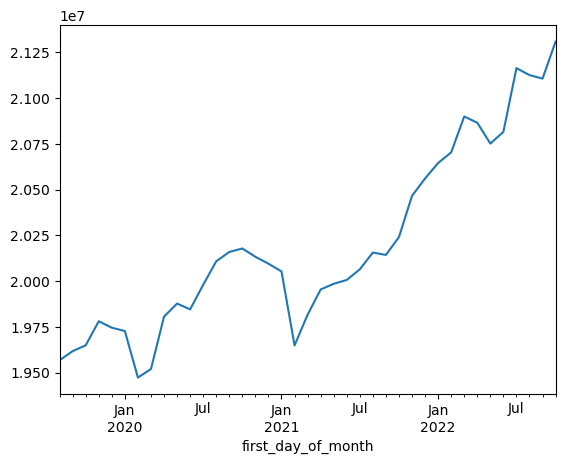

In [40]:
df_train.groupby("first_day_of_month")["active"].sum().plot()